***
#### About this document 
_This is the assignment for the UCL CASA module Data Science for Spatial Systems (CASA0006) <br>This is a self contained Jupyter notebook with structure introduction, discussion and embeded code and references._

_This notebook is structured into five sections. The first section provides an introduction and literature review. The second section validates, cleans, and conducts exploratory analysis on the data. The third section provides a detailed description of the methodology. The fourth section analyzes the experimental results. The fifth section elucidates the research conclusions and conducts a discussion._
<br>
<br>
**Data is availble [here](https://github.com/SeasoningPackkk/data)**<br>
**Code is availble [here](https://github.com/SeasoningPackkk/data/blob/main/DSSS_final.ipynb)**<br>
<br>**Word Count: 2082**<br>
***

# Comparison of machine learning methods for predicting the severity of road accidents based on an imbalanced dataset
<p style="color:DimGray; text-align:left; font-size:20px"><i> Using Data from England (2017-2021) </i></p>
<a id="ID_title"></a>

***

## 1 Introduction and literature review

Traffic accidents have become one of the major public safety concerns worldwide, causing significant loss of life and economic damage, with approximately 1.3 million deaths annually (WHO, 2018). This has led researchers to focus on understanding the characteristics of traffic accidents and proposing measures to reduce their frequency and severity. Predicting accident severity and identifying related factors are one of the crucial aspects, aiding traffic management authorities in prompt response and accident resolution and improving the safety and efficiency of transportation (Fiorentini and Losa, 2020). 

Machine Learning (ML) algorithms have been widely applied and demonstrated remarkable performance in predicting accident severity and exploring accident features due to their ability to handle complex data structures and nonlinear relationships. Logistic Regression (LR), Decision Tree (DT), Random Forest (RF), Support Vector Machines (SVM), Neural Networks (NN), and Naïve Bayes (NB) are used for predicting accident severity, as summarized by Fiorentini and Losa (2020). Additionally, Malik et al. (2021) applied and compared NB, LR, DT, RF, Bagging, and AdaBoost to predict severity, demonstrating that RF, DT, and Bagging performed better. However, different models have inherent limitations. For instance, Niyogisubizo et al. (2023) put forward that SVM and ANN face challenges in interpretability, while Decision Tree suffer from overfitting and inaccurate precision. To address these issues, they combined Balanced Bagging Classifier (BBC) and Light Gradient Boosting Machine (LGBM) using a sum-rule voting, enhancing the accuracy and alleviating bias and variance problems  (Niyogisubizo et al., 2023).
On the other hand, extensive research has revealed key features influencing accident severity. For instance, Kumeda et al. (2019) identified road class and number, lighting conditions, and vehicle count as critical features for 2016 traffic accidents in the UK. However, the literature review conducted by Megnidio-Tchoukouegno and Adedeji (2023) suggests that the key features can vary in different regions and at different times, so context-specific discussions on the key features are necessary. 

Furthermore, Fiorentini and Losa (2020) highlighted that many studies overlook the severe imbalance in datasets, leading to a significant drop in classifier performance in predicting the minority class. To overcome these challenges, resampling techniques including oversampling and undersampling can be employed. Additionally, for evaluating classifier performance on imbalanced data, metrics such as balanced accuracy, geometric mean, and Cohen's kappa are recommended (Fiorentini and Losa, 2020; Ghandour, Hammoud and Al-Hajj, 2020).

Based on the literature, it is evident that many studies have not considered the imbalanced characteristics of traffic accident datasets (Fiorentini and Losa, 2020). And these studies primarily focus on exploring the features that influence accidents but fail to consider the specific categories within them, thereby limiting their ability to provide targeted guidance for traffic improvement measures. Additionally, most of the existing research in the UK relies on data before 2020, which may not capture the rapidly evolving urban traffic patterns and related policies, such as the impact of lockdown measures during the year 2020. Therefore, there is a need for more recent research.

Consequently, the objective of this study is to predict the severity categories of accidents based on an imbalanced dataset covering nearly five years of data in England and to identify the important features and their specific categories that influence accidents.

### Research question
Based on this, the following three questions are proposed. 

**RQ1** What factors play a key role in predicting the severity of traffic accidents in England? 

**RQ2** Which machine learning algorithm can accurately predict the severity of accidents in the highly imbalanced UK traffic accident dataset? 

**RQ3** What possible patterns or trends exist in the England accidents over the past five years? 


## 2 Presentation of data

This notebook utilizes two datasets: [Accident and Vehicle](https://www.data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data); the former describes the key features of accidents, such as location, severity, while the latter includes features related to the involved vehicles, such as vehicle type and engine capacity. All features have been encoded numerically and released and verified by the UK Department of Transportation. These datasets record traffic accidents that occurred in England between 2017 and 2021 and can be merged using the accident index.

The newly merged dataset was subjected to a thorough investigation of structure, quality, and distribution to validate and clean the data. 

### Packages

In [67]:
# Due to the possibility of high RAM usage causing the Jupyter Notebook kernel 
# to restart or long running times, certain cells have been set to manual execution.

# count running time
import time
start_time_1 = time.time()


In [68]:
# Additional packages
!pip install geopandas # Not sure if installation is required
!pip install imblearn
!pip install rfpimp
!pip install missingno

# Data manipulation
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.stats import f_oneway

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.pyplot import figure
import seaborn as sns
import missingno as msno
import geopandas as gpd

# Feature encoding
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler

# Modeling
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score, cohen_kappa_score
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced
import rfpimp

# Clustering
import sklearn.cluster as sklc
import sklearn.metrics as sklm



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 2.1 Data Validation and Cleansing

In [69]:
# Load datasets
accidents = pd.read_csv('https://raw.githubusercontent.com/SeasoningPackkk/data/main/dft-road-casualty-statistics-accident-last-5-years.csv')
vehicles = pd.read_csv('https://raw.githubusercontent.com/SeasoningPackkk/data/main/dft-road-casualty-statistics-vehicle-last-5-years.csv')

<ipython-input-69-6e47e64d3691>:2: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents = pd.read_csv('https://raw.githubusercontent.com/SeasoningPackkk/data/main/dft-road-casualty-statistics-accident-last-5-years.csv')
<ipython-input-69-6e47e64d3691>:3: DtypeWarning: Columns (0,2,24) have mixed types. Specify dtype option on import or set low_memory=False.
  vehicles = pd.read_csv('https://raw.githubusercontent.com/SeasoningPackkk/data/main/dft-road-casualty-statistics-vehicle-last-5-years.csv')


#### 2.1.1 Structure Investigation

In [70]:
# According to the prompt, there are mixed data types in some data
# As we can see, categorical variables are recorded as numeric which
# will be further processed after removing missing values
print(accidents.info())
print(vehicles.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562439 entries, 0 to 562438
Data columns (total 36 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               562439 non-null  object 
 1   accident_year                                562439 non-null  int64  
 2   accident_reference                           562439 non-null  object 
 3   location_easting_osgr                        562306 non-null  float64
 4   location_northing_osgr                       562306 non-null  float64
 5   longitude                                    562296 non-null  float64
 6   latitude                                     562296 non-null  float64
 7   police_force                                 562439 non-null  int64  
 8   accident_severity                            562439 non-null  int64  
 9   number_of_vehicles                           562439 non-nul

In [71]:

# The label of the category variable should be mapped to the corresponding value here 
# to better view the variable category
# But the missing values ​​represented by -1 can be better cleaned up with numeric values
# So this step will be done after cleaning outliers

# Load datasets guide
df = pd.read_csv('https://raw.githubusercontent.com/SeasoningPackkk/data/main/Road-Safety-Open-Dataset-Data-Guide.csv')

# Create the data dictionary 
map_dict = defaultdict(dict)
numeric_col = []

for i in range(len(df)):
    row = df.iloc[i]
    field = row['field name']
    code = row['code/format']
    label = row['label']
    map_dict[field][str(code)] = label

numeric_col = []

for field, code_label_dict in map_dict.items():
    if 'nan' in code_label_dict:
        numeric_col.append(field)


#print(map_dict)
#print(numeric_col)


# Mapping the non-numeric columns in the dataset according to map_dict
#  will be applied later
#for field in accidents.columns:
#    if field not in numeric_col and field not in ['time', 'date']:
#        accidents[field] = accidents[field].apply(lambda x: map_dict[field].get(str(x), x))


#for field in vehicles.columns:
#    if field not in numeric_col and field != 'accident_index':
#        vehicles[field] = vehicles[field].apply(lambda x: map_dict[field].get(str(x), x))



In [72]:
# Merge two datasets into one
merged_df = pd.merge(accidents, vehicles, on='accident_index')
print(accidents.shape)
print(vehicles.shape)
print(merged_df.shape)
print(merged_df.info())

(562439, 36)
(1035534, 28)
(830704, 63)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 830704 entries, 0 to 830703
Data columns (total 63 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               830704 non-null  object 
 1   accident_year_x                              830704 non-null  int64  
 2   accident_reference_x                         830704 non-null  object 
 3   location_easting_osgr                        830470 non-null  float64
 4   location_northing_osgr                       830470 non-null  float64
 5   longitude                                    830454 non-null  float64
 6   latitude                                     830454 non-null  float64
 7   police_force                                 830704 non-null  int64  
 8   accident_severity                            830704 non-null  int64  
 9   number_of_vehicles 

In [73]:
# Duplicate features are generated and deleted accident_year_y accident_reference_y
merged_df = merged_df.drop(['accident_year_y', 'accident_reference_y'], axis=1)

In [74]:

# Datatype should be checked first to ensure that it is consistent with the actual situation.
# Then, check for missing values ​​and perform necessary processing. 
# If a variable has the wrong data type, all operations on that variable will not work, including handling of missing values.
# Check the numeric and non-numeric types
# Some of the categorical variables will be further processed in the follow-up

merged_df.select_dtypes(exclude="number").sample(5)

,accident_index,accident_reference_x,date,time,local_authority_ons_district,local_authority_highway,lsoa_of_accident_location,generic_make_model,lsoa_of_driver
610042,20201372K0135,1372K0135,20/02/2020,02:49,E08000035,E08000035,E01011339,BMW 5 SERIES,E01011339
151535,2017440154171,440154171,25/04/2017,15:45,E07000090,E10000014,E01022922,-1,E01022835
406130,2019010161532,010161532,04/02/2019,19:37,E09000030,E09000030,E01032769,-1,-1
204506,201797UA02305,97UA02305,28/05/2017,14:50,S12000021,S12000021,-1,-1,-1
289698,2018230344032,230344032,11/11/2018,11:30,E07000221,E10000031,E01031242,-1,E01010195


In [75]:
merged_df.describe(exclude="number")
#The data type is correct, but there are many missing values (-1) that 
#should be noted in subsequent checks.

,accident_index,accident_reference_x,date,time,local_authority_ons_district,local_authority_highway,lsoa_of_accident_location,generic_make_model,lsoa_of_driver
count,830704,830704,830704,830704,830704,830704,830704,830704,830704
unique,451274,447341,1826,1440,383,208,33557,914,34658
top,2018460297266,460297266,02/11/2018,17:00,E08000025,E10000030,-1,-1,-1
freq,24,24,914,8149,22626,27632,43162,522276,319634


In [76]:
merged_df.describe(include="number")

,accident_year_x,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,...,vehicle_left_hand_drive,journey_purpose_of_driver,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,driver_imd_decile,driver_home_area_type
count,830704.000000,830470.000000,8.304700e+05,830454.000000,830454.000000,830704.000000,830704.000000,830704.000000,830704.000000,830704.000000,...,830704.000000,830704.000000,830704.000000,830704.000000,830704.000000,830704.000000,830704.000000,830704.000000,830704.000000,830704.000000
mean,2018.758715,447530.066283,2.973078e+05,-1.319322,52.564060,28.000058,2.790213,2.110658,1.362241,4.113540,...,1.298261,4.687142,1.465754,35.269875,5.901112,1375.482438,0.962246,5.677158,3.783517,0.824390
std,1.400887,89865.896684,1.502446e+05,1.322617,1.352963,24.533090,0.440442,0.865954,0.823836,1.923309,...,1.512085,1.962026,0.669757,20.711153,3.126021,1593.961411,1.513240,6.153678,3.525453,1.113144
min,2017.000000,64084.000000,1.023500e+04,-7.525273,49.912362,1.000000,1.000000,1.000000,1.000000,1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,2018.000000,389226.250000,1.789180e+05,-2.161805,51.496109,6.000000,3.000000,2.000000,1.000000,2.000000,...,1.000000,2.000000,1.000000,23.000000,5.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000
50%,2019.000000,447085.500000,2.781880e+05,-1.303732,52.395551,21.000000,3.000000,2.000000,1.000000,4.000000,...,1.000000,6.000000,1.000000,35.000000,6.000000,1390.000000,1.000000,4.000000,4.000000,1.000000
75%,2020.000000,524939.000000,3.951530e+05,-0.197095,53.451678,44.000000,3.000000,2.000000,1.000000,6.000000,...,1.000000,6.000000,2.000000,50.000000,8.000000,1910.000000,2.000000,10.000000,7.000000,1.000000
max,2021.000000,655391.000000,1.209512e+06,1.759641,60.763722,99.000000,3.000000,24.000000,59.000000,7.000000,...,9.000000,6.000000,3.000000,101.000000,11.000000,99999.000000,12.000000,96.000000,10.000000,3.000000


In [77]:
print(merged_df.info())

# A preliminary examination of the data structure reveals that the data types include obeject\category\numeric
# There are 830,704 records with 60 columns
# Some data type is incorrect and needs to be converted
# Note that the data conversion will be done after that time as the outliers are cleaned up by numeric coding.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 830704 entries, 0 to 830703
Data columns (total 61 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               830704 non-null  object 
 1   accident_year_x                              830704 non-null  int64  
 2   accident_reference_x                         830704 non-null  object 
 3   location_easting_osgr                        830470 non-null  float64
 4   location_northing_osgr                       830470 non-null  float64
 5   longitude                                    830454 non-null  float64
 6   latitude                                     830454 non-null  float64
 7   police_force                                 830704 non-null  int64  
 8   accident_severity                            830704 non-null  int64  
 9   number_of_vehicles                           830704 non-nul

### 2.1.2 Quality Investigation 

In [78]:
# Normally feature removal would be done after the missing values have been processed, 
# but as this dataset is too large.

# Delete irrelevant columns but keep the 'accident_index' to check duplication
de = merged_df.drop(['accident_reference_x', 'vehicle_reference', 'did_police_officer_attend_scene_of_accident'], axis=1)

# Delete redundant location-related columns
de = de.drop(['location_easting_osgr', 'location_northing_osgr', 'police_force', 'lsoa_of_accident_location'], axis=1)
de = de.drop(['local_authority_district', 'local_authority_ons_district', 'local_authority_highway'], axis=1)

# Delete redundant age_band_of_driver-related column
de = de.drop(['age_of_driver'], axis=1)

# Delete redundant driver_home_area_type-related column
# These two features provide geographical information about the driver 
# but the information provided by driver_home_area_type is less sensitive
# And lsoa_of_driver may introduce more details 
de = de.drop(['lsoa_of_driver'], axis=1)

de.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 830704 entries, 0 to 830703
Data columns (total 49 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   accident_index                           830704 non-null  object 
 1   accident_year_x                          830704 non-null  int64  
 2   longitude                                830454 non-null  float64
 3   latitude                                 830454 non-null  float64
 4   accident_severity                        830704 non-null  int64  
 5   number_of_vehicles                       830704 non-null  int64  
 6   number_of_casualties                     830704 non-null  int64  
 7   date                                     830704 non-null  object 
 8   day_of_week                              830704 non-null  int64  
 9   time                                     830704 non-null  object 
 10  first_road_class                

In [79]:
# Before focusing on the actual content stored in these features, 
# let's first take a look at the overall quality of the dataset. 
# To have a over view of aspects such as duplicates, missing values,
# and unnecessary entries or record errors in the dataset.
duplicated_rows = de[de.duplicated(subset=['accident_index'], keep=False)]

In [80]:
duplicated_rows.head(5)
#Because the accident corresponds to multiple vehicles, 
#indexes are duplicated, but there is no need to delete them

,accident_index,accident_year_x,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,...,vehicle_left_hand_drive,journey_purpose_of_driver,sex_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model,driver_imd_decile,driver_home_area_type
0,2017010001708,2017,-0.080107,51.650061,1,2,3,05/08/2017,7,03:12,...,1,6,1,5,1997,2,1,-1,-1,-1
1,2017010001708,2017,-0.080107,51.650061,1,2,3,05/08/2017,7,03:12,...,1,6,1,4,-1,-1,-1,-1,-1,-1
2,2017010009342,2017,-0.173845,51.522425,3,2,1,01/01/2017,1,01:30,...,1,6,1,6,1797,8,8,-1,9,1
3,2017010009342,2017,-0.173845,51.522425,3,2,1,01/01/2017,1,01:30,...,1,6,1,7,2204,2,12,-1,2,1
4,2017010009344,2017,-0.052969,51.514096,3,3,1,01/01/2017,1,00:30,...,1,6,3,-1,-1,-1,-1,-1,-1,-1


In [81]:
#Replace all -1 in numeric and string data with NaN for observing missing features
df2=de.replace(-1, np.nan)
df2=df2.replace('-1', 'NaN')
df2.sample(5)

,accident_index,accident_year_x,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,...,vehicle_left_hand_drive,journey_purpose_of_driver,sex_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model,driver_imd_decile,driver_home_area_type
515943,2019450872128,2019,-0.385684,51.350654,2,2,1,28/08/2019,4,13:21,...,1.0,5.0,2.0,11.0,1299.0,1.0,15.0,NaN,8.0,1.0
664021,2020430233641,2020,-0.714126,52.039232,3,1,1,19/07/2020,1,00:10,...,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33026,2017010065825,2017,-0.176857,51.403588,3,2,1,21/10/2017,7,21:50,...,1.0,1.0,1.0,6.0,108.0,1.0,8.0,NaN,6.0,1.0
632480,2020220966437,2020,-2.382984,52.476344,3,2,1,18/07/2020,7,16:45,...,1.0,5.0,1.0,6.0,1199.0,1.0,17.0,VAUXHALL CORSA,1.0,1.0
600859,2020070087343,2020,-2.693128,52.998073,3,2,2,09/02/2020,1,19:46,...,1.0,6.0,1.0,8.0,1995.0,2.0,14.0,BMW 5 SERIES,2.0,1.0


In [82]:
# At the same time, when looking up the data description, 
# we can notice that in addition to the missing values ​​representing -1, 
# there are also some meaningless values, which must also be processed
# Find the corresponding values ​​of the following features in df2, 
# calculate occurrences and the proportion of the total number of samples

feature_dict = {
    'first_road_class': 6,
    'first_road_number': 0,
    'road_type': 9,
    'speed_limit': 99,
    'junction_detail': 99,
    'junction_control': 9,
    'second_road_class': 6,
    'second_road_number': 0,
    'pedestrian_crossing_human_control': 9,
    'pedestrian_crossing_physical_facilities': 9,
    'light_conditions': 7,
    'weather_conditions': 9,
    'road_surface_conditions': 9,
    'special_conditions_at_site': 9,
    'carriageway_hazards': 9,
    'urban_or_rural_area': 3,
    'vehicle_type': 99,
    'towing_and_articulation': 9,
    'vehicle_manoeuvre': 99,
    'vehicle_direction_from': 9,
    'vehicle_direction_to': 9,
    'vehicle_location_restricted_lane': 99,
    'junction_location': 9,
    'skidding_and_overturning': 9,
    'hit_object_in_carriageway': 99,
    'vehicle_leaving_carriageway': 9,
    'hit_object_off_carriageway': 99,
    'first_point_of_impact': 9,
    'vehicle_left_hand_drive': 9,
    'journey_purpose_of_driver': 6,
    'sex_of_driver': 3
}

In [83]:
# calculate occurrences of its corresponding value and the proportion of 
# the total number of samples

for feature, value in feature_dict.items():
    mlesscount = df2[df2[feature] == value][feature].count()
    mlesspercent = mlesscount / len(df2) * 100
    df2.loc[df2[feature] == value, feature] = np.nan
    #print(f"{feature}_{value}: count={mlesscount}, percent={mlesspercent:.4f}")
    

Running the code...


<Figure size 800x500 with 0 Axes>

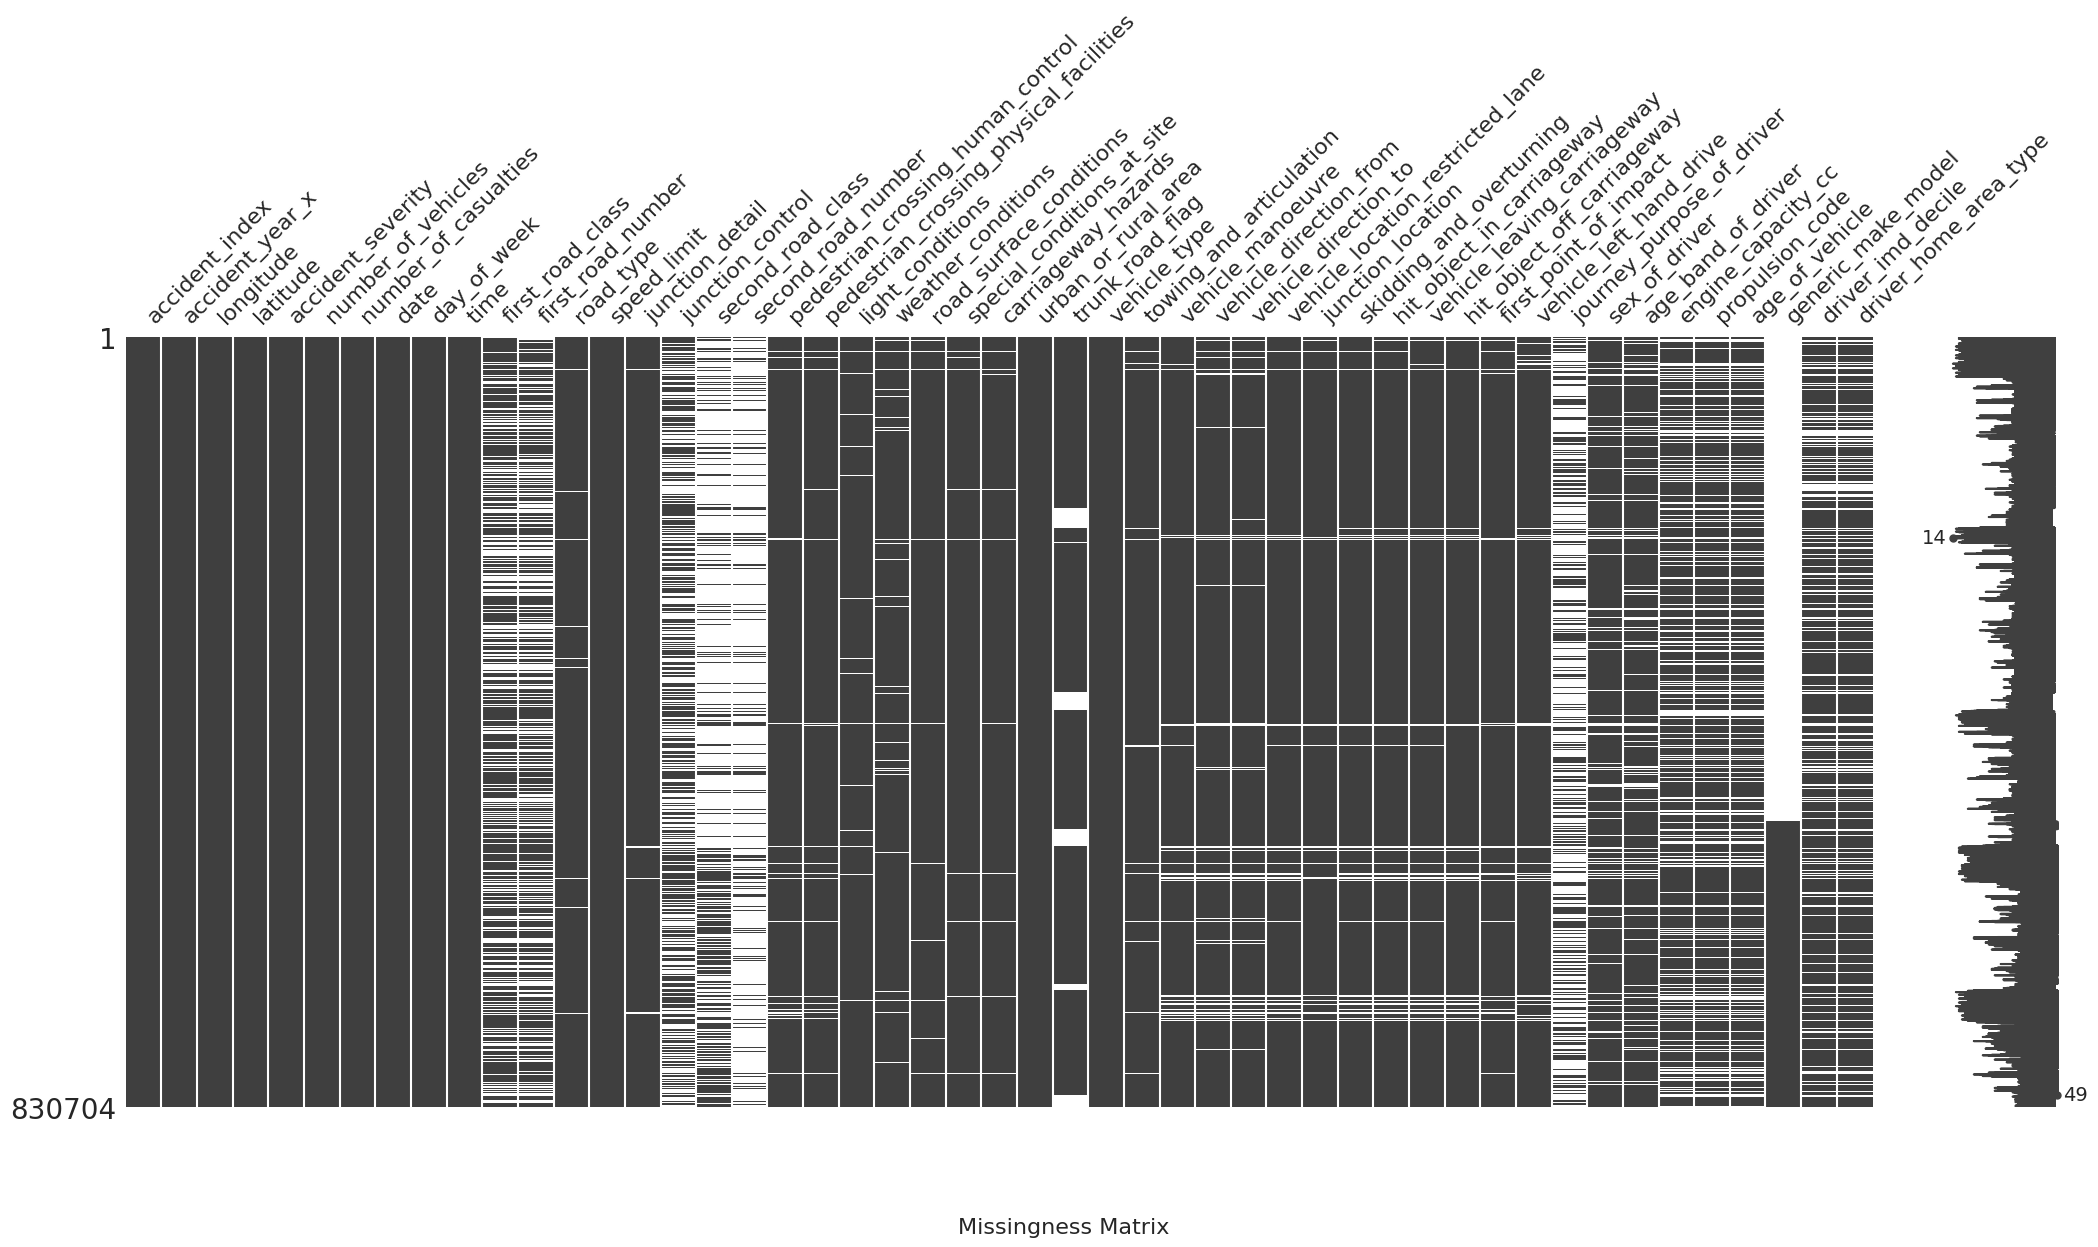

In [84]:
# It may automatically restart jupyternotebook kernal due to high RAM usage, 
# so it is set to non-automatic operation
# And inserted the picture that has been plotted
# The plot was inserted in markdown
run_code= False
if run_code:
  print("Running the code...")
  import missingno as msno

  # Observing structural defects
  plt.figure(figsize=(8,5))
  msno.matrix(df2)
  plt.suptitle('Missingness Matrix', fontsize=16, x = 0.5, y=0)

  plt.show()
else:
    # Code to be executed when the toggle switch is set to False
    print("Code execution is skipped.")

<img src="https://raw.githubusercontent.com/SeasoningPackkk/data/main/missing_matrix.jpeg">

In [85]:
# Calculate the number and proportion of missing values ​​for each column
missing_count = df2.isna().sum().sort_values(ascending=False)
missing_percent = missing_count / len(df2) * 100
# print("Missing value counts:\n", missing_count)
# print("\nMissing value percentages:\n", missing_percent)

<ipython-input-86-3f6a00bf9c39>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(missing_percent[missing_cols].index, rotation=90)


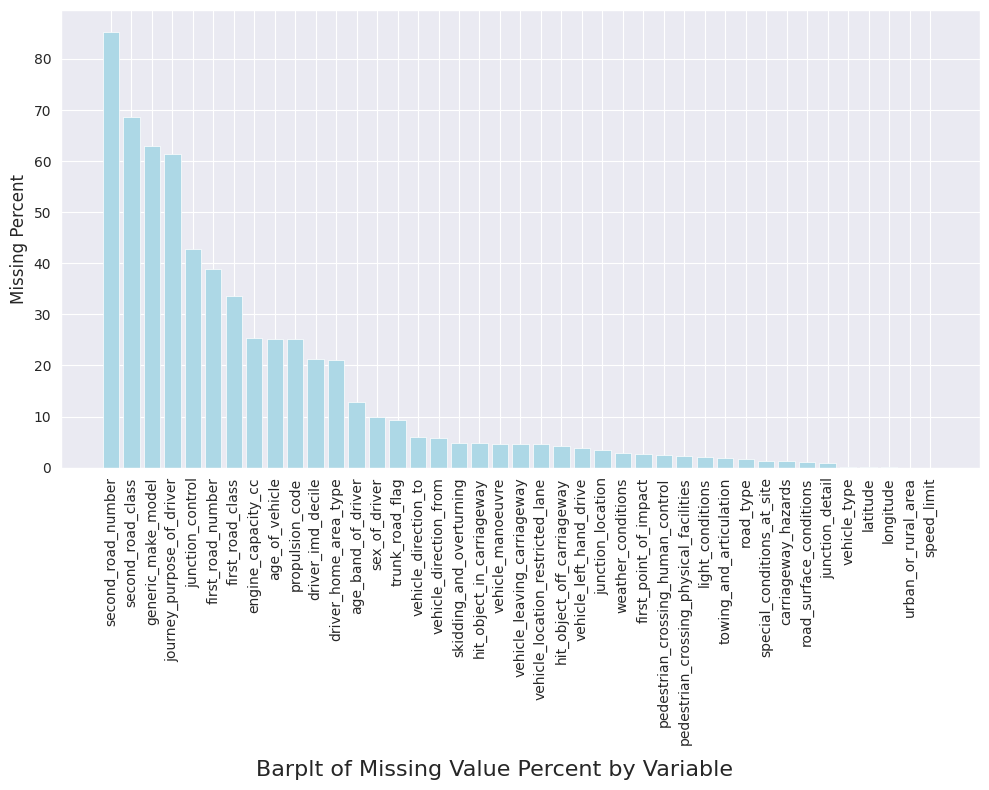

In [86]:
# Select variables with missing values
missing_cols = missing_count[missing_count > 0].index


fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(missing_percent[missing_cols].index, missing_percent[missing_cols].values, color='lightblue')
ax.set_xticklabels(missing_percent[missing_cols].index, rotation=90)
ax.set_ylabel('Missing Percent')
plt.suptitle('Barplt of Missing Value Percent by Variable', fontsize=16, x = 0.5, y=0.0)

fig.tight_layout()

plt.show()


In [87]:
# Select the missing features
missing_df = pd.DataFrame({'Missing Count': missing_count, 'Missing Percent': missing_percent})
missing_df = missing_df[missing_df['Missing Count'] > 0]
print(missing_df)

                                         Missing Count  Missing Percent
second_road_number                              708650        85.307161
second_road_class                               570576        68.685838
generic_make_model                              522276        62.871492
journey_purpose_of_driver                       509864        61.377338
junction_control                                355537        42.799481
first_road_number                               322668        38.842717
first_road_class                                278714        33.551542
engine_capacity_cc                              211086        25.410495
age_of_vehicle                                  209129        25.174912
propulsion_code                                 208591        25.110148
driver_imd_decile                               175931        21.178543
driver_home_area_type                           175370        21.111009
age_band_of_driver                              106396        12

In [88]:
# Create three groups of features based on their missing percentages
a = missing_df[missing_df['Missing Percent'] > 60].index
b = missing_df[(missing_df['Missing Percent'] > 10) & (missing_df['Missing Percent'] <= 60)].index
c = missing_df[missing_df['Missing Percent'] <= 10].index

# For features whose missing ratio is greater than 60%, the entire column is deleted 
# Features with a missing ratio between 60% and 10% should be filled, 
# but their missing values ​​is deleted in consideration of 
# computing performance and prediction accuracy 
# For features with a missing ratio 
# between 10%, delete their missing values ​​considering the prediction accuracy

In [89]:
# Remove the columns in group a from df2
df3=df2.drop(columns=a)
df3.shape

(830704, 45)

In [90]:
# Remove the samples containing missing values in group c from df2
df4 = df3.dropna(subset=c, how='any')
df4.shape

(609482, 45)

In [91]:
# Remove the samples containing missing values in group b from df2
df5=df4.dropna(subset=b, how='any')
df5.shape

(155175, 45)

#### Datatype Conversion

In [92]:
# After clearing missing values, 
# map and convert their variable types to better understand the data
dfm=df5.copy()

In [93]:
# Mapping the non-numeric columns in the dataset according to map_dict

for field in dfm.columns:
    #print(field)
    if field not in numeric_col and field not in ['time', 'date']:
        dfm[field] = dfm[field].apply(lambda x: map_dict[field].get(str(int(x)), x))

In [94]:
dfm.sample(5).T

,350354,481814,273569,638104,797517
accident_index,2018460275600,2019230895218,2018200289681,2020302001705,2021361086996
accident_year_x,2018,2019,2018,2020,2021
longitude,0.992844,-1.481107,-1.984553,-1.462171,1.239788
latitude,51.255118,52.558009,52.465853,52.924119,52.669772
accident_severity,Slight,Slight,Serious,Slight,Slight
number_of_vehicles,3,2,2,3,2
number_of_casualties,1,1,1,1,2
date,07/03/2018,22/10/2019,18/04/2018,30/12/2020,04/08/2021
day_of_week,Wednesday,Tuesday,Wednesday,Wednesday,Wednesday
time,14:30,00:16,15:44,12:30,07:25


In [95]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155175 entries, 2 to 818006
Data columns (total 45 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   accident_index                           155175 non-null  object 
 1   accident_year_x                          155175 non-null  int64  
 2   longitude                                155175 non-null  float64
 3   latitude                                 155175 non-null  float64
 4   accident_severity                        155175 non-null  object 
 5   number_of_vehicles                       155175 non-null  int64  
 6   number_of_casualties                     155175 non-null  int64  
 7   date                                     155175 non-null  object 
 8   day_of_week                              155175 non-null  object 
 9   time                                     155175 non-null  object 
 10  first_road_class                

In [96]:
# Convert time variable to pandas time type
dfm['Date']= pd.to_datetime(dfm.date, format='%d/%m/%Y')
dfm = dfm.drop('date', axis=1)

In [97]:
# convert time to period
dfm['hour'] = pd.to_datetime(dfm['time'], format='%H:%M').dt.hour
dfm['time_period'] = dfm['hour'].apply(lambda x: 'early_morning' if (x>=5 and x<7) else
                                                 'morning_rush' if (x>=7 and x<10) else
                                                 'office_hours' if (x>=10 and x<16) else
                                                 'afternoon_rush' if (x>=16 and x<19) else
                                                 'evening' if (x>=19 and x<23) else
                                                 'night')
df5['time_period']= dfm['hour']
dftp = dfm.drop(['time', 'hour'], axis=1)


<ipython-input-97-2e018ba7f823>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['time_period']= dfm['hour']


In [98]:
# Convert columns to category
df6=dftp.copy()

cols = ['accident_year_x',
       'accident_severity', 'day_of_week', 'first_road_class', 'first_road_number',
       'road_type', 'junction_detail', 'junction_control',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'trunk_road_flag', 'vehicle_type',
        'towing_and_articulation', 'vehicle_manoeuvre', 'vehicle_direction_from', 
        'vehicle_direction_to','vehicle_location_restricted_lane', 'junction_location', 
        'skidding_and_overturning', 'hit_object_in_carriageway', 
        'vehicle_leaving_carriageway', 'hit_object_off_carriageway',
        'first_point_of_impact', 'vehicle_left_hand_drive',
        'age_band_of_driver', 'propulsion_code', 'driver_imd_decile', 
        'driver_home_area_type', 'sex_of_driver', 'time_period']
        
df6[cols] = df6[cols].astype('category')

In [99]:
df6.info()
# So far, the basic missing value processing and 
# variable type conversion have been completed

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155175 entries, 2 to 818006
Data columns (total 45 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   accident_index                           155175 non-null  object        
 1   accident_year_x                          155175 non-null  category      
 2   longitude                                155175 non-null  float64       
 3   latitude                                 155175 non-null  float64       
 4   accident_severity                        155175 non-null  category      
 5   number_of_vehicles                       155175 non-null  int64         
 6   number_of_casualties                     155175 non-null  int64         
 7   day_of_week                              155175 non-null  category      
 8   first_road_class                         155175 non-null  category      
 9   first_road_number         

### 2.1.3 Distribution Investigation

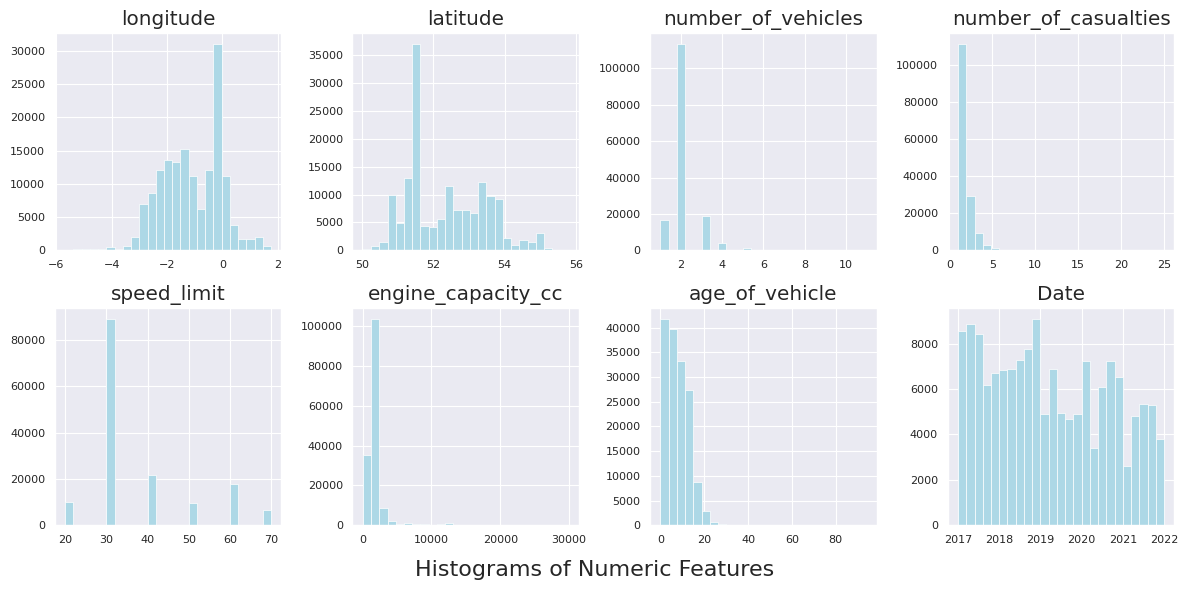

In [100]:
import seaborn as sns
sns.set_style("darkgrid")
df6.hist(bins=25, figsize=(12, 6), layout=(2, 4), color="lightblue")
plt.suptitle('Histograms of Numeric Features', fontsize=16, x=0.5, y=0.0)

# Adjust x-axis tick label font size for each subplot
for ax in plt.gcf().axes:
    ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()



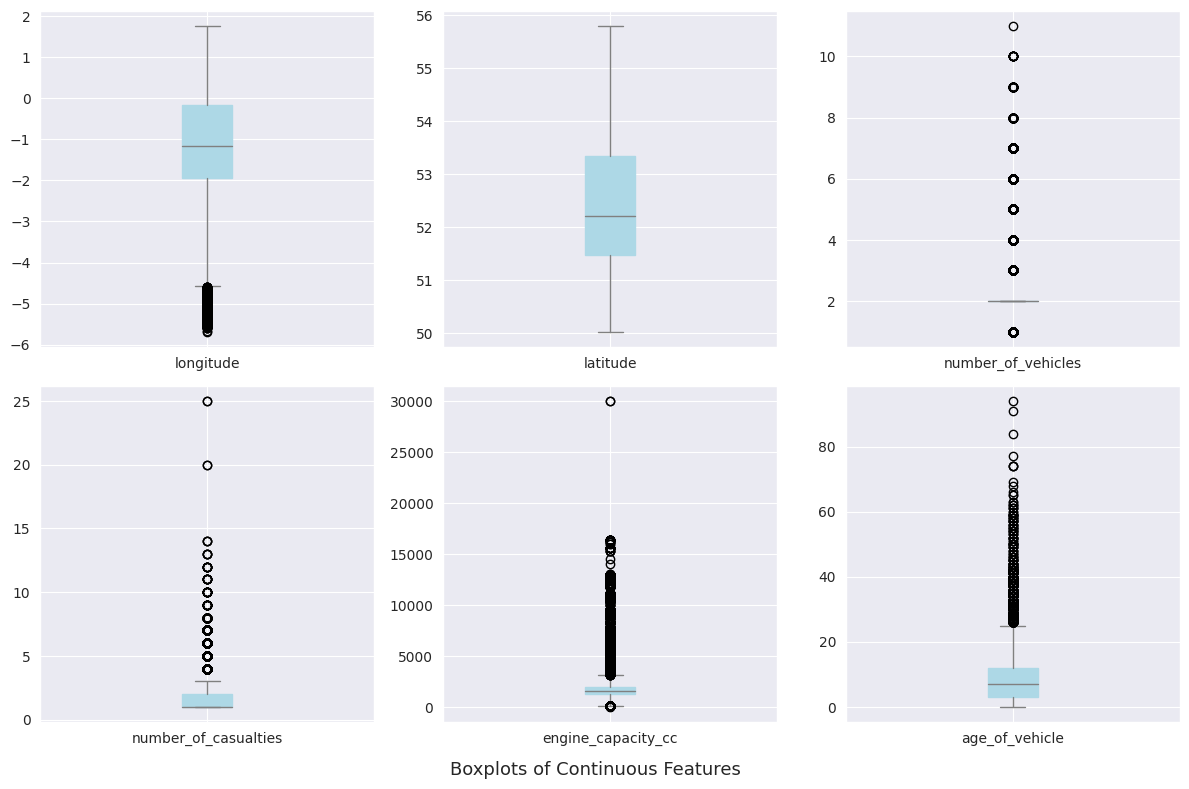

In [101]:

import seaborn as sns
# Create boxplot for continuous variables
continuous_cols = ['longitude', 'latitude', 'number_of_vehicles', 
                   'number_of_casualties', 'engine_capacity_cc', 'age_of_vehicle']
con_data = df5[continuous_cols]
sns.set_style("darkgrid")
con_data.plot(subplots=True, kind='box', layout=(2,3), patch_artist=True,
              figsize=(12,8), color={'boxes': 'lightblue', 'whiskers': 'grey', 'medians': 'grey', 'caps': 'grey'})

plt.suptitle('Boxplots of Continuous Features', fontsize=13, x = 0.5, y=0.0)
plt.tight_layout()

# Outliers for continuous features are true and valid values 
# Not normalised here because of the potential for data leakage

# max_number_of_casualties_idx = df6['number_of_casualties'].idxmax()
# max_number_of_casualties_sample = df6.loc[max_number_of_casualties_idx]
# print(max_number_of_casualties_sample)


# max_engine_capacity_idx = df6['engine_capacity_cc'].idxmax()
# max_engine_capacity_sample = df6.loc[max_engine_capacity_idx]
# print(max_engine_capacity_sample)


# max_age_of_vehicle_idx = df6['age_of_vehicle'].idxmax()
# max_age_of_vehicle_sample = df6.loc[max_age_of_vehicle_idx]
# print(max_age_of_vehicle_sample)

# print(df6[df6['age_of_vehicle'] > 70])

# pd.set_option('display.max_columns', None)
# print(df5[df5['age_band_of_driver'] < 3])

#Check the outliers of each feature
#it can be judged that they are all real and effective values rather than caused by recording errors
#For example, 29988 in engine_capacity_cc may be because the vehicle is a large truck with a load of 3.5t
#number_of_casualties is because the vehicle is a bus


In [102]:
#df6.select_dtypes(exclude="number").columns
cate=['accident_severity', 'day_of_week',
       'first_road_class', 'first_road_number', 'road_type', 'junction_detail',
       'junction_control', 'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'trunk_road_flag', 'vehicle_type',
       'towing_and_articulation', 'vehicle_manoeuvre',
       'vehicle_direction_from', 'vehicle_direction_to',
       'vehicle_location_restricted_lane', 'junction_location',
       'skidding_and_overturning', 'hit_object_in_carriageway',
       'vehicle_leaving_carriageway', 'hit_object_off_carriageway',
       'first_point_of_impact', 'vehicle_left_hand_drive', 'sex_of_driver',
       'age_band_of_driver', 'propulsion_code', 'driver_imd_decile',
       'driver_home_area_type','time_period']#time period

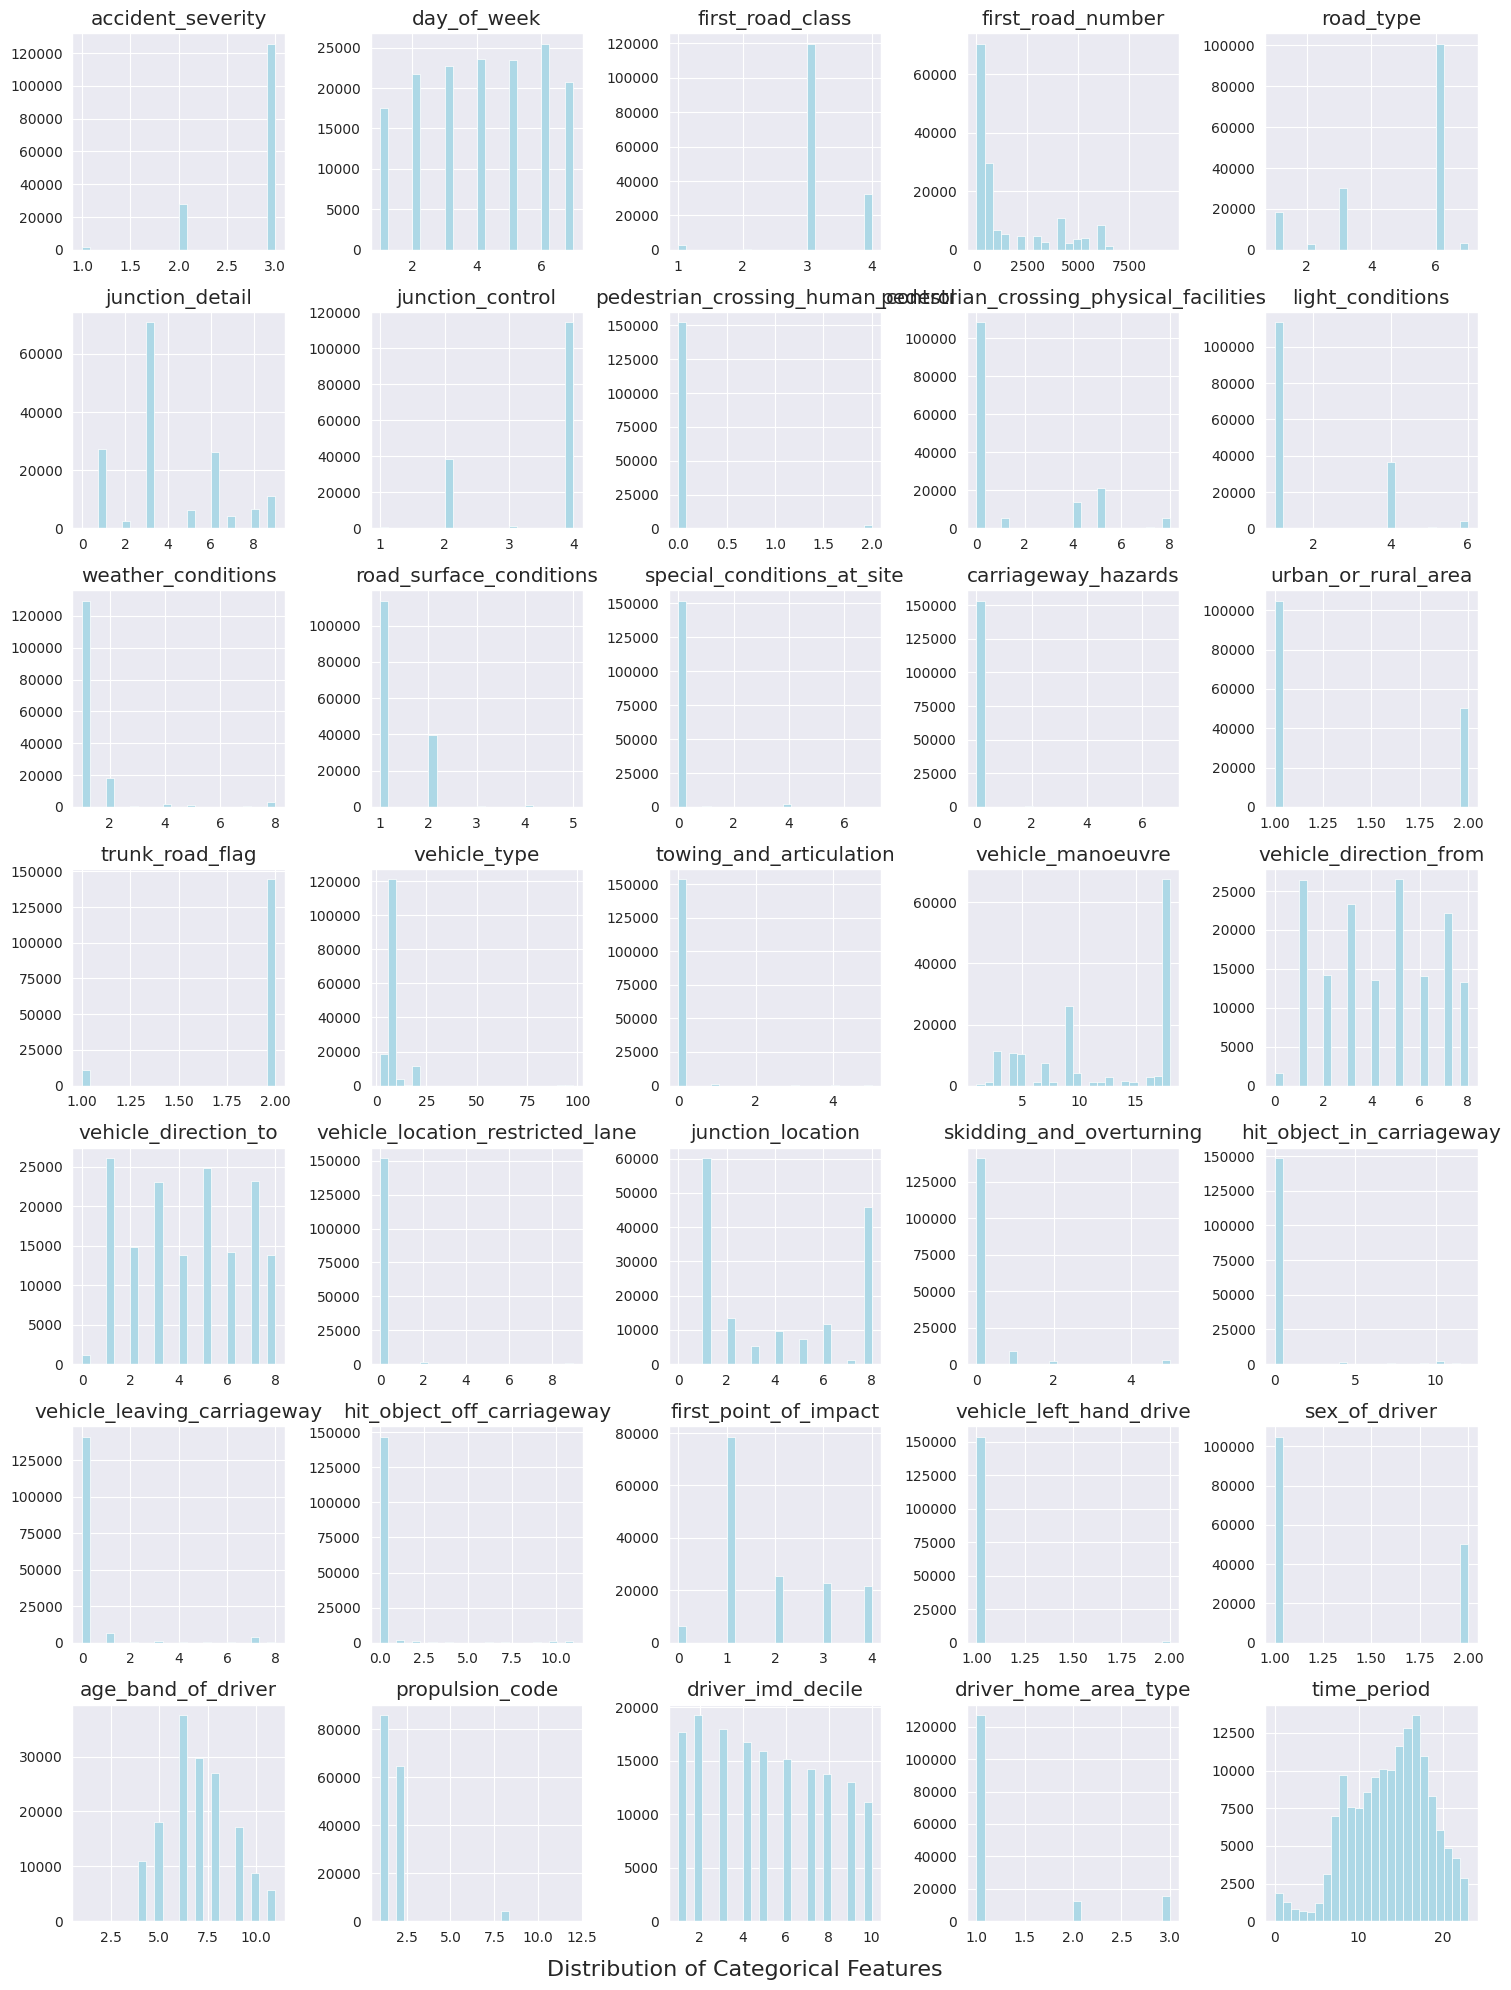

Runtime duration: 11.21 seconds


In [103]:
start_time = time.time()

# To facilitate the observation of the distribution the categorical 
# variables are plotted in histogram form using their numerical codes

sns.set_style("darkgrid")
df5[cate].hist(bins=24, figsize=(15, 20), layout=(7, 5), color="lightblue")
plt.suptitle('Distribution of Categorical Features', fontsize=16, x=0.5, y=0.0)
plt.tight_layout()
plt.show()
# This image may take a long time to draw please be patient
end_time = time.time()
duration = end_time - start_time

# Print the runtime duration
print("Runtime duration: {:.2f} seconds".format(duration))


In [104]:

f_values = pd.DataFrame(columns=['Feature', 'F-value', 'P-value', 'Variance Ratio'])

for col in df5.select_dtypes(exclude='object').columns:
    if col != 'accident_severity':
        group1 = df5[df5['accident_severity'] == 1][col].dropna()
        group2 = df5[df5['accident_severity'] == 2][col].dropna()
        group3 = df5[df5['accident_severity'] == 3][col].dropna()

        f_value, p_value = f_oneway(group1, group2, group3)

        # Calculate variance ratio and append to dataframe
        f_ratio = f_value / (group1.var() + group2.var() + group3.var())
        f_values = pd.concat([f_values, pd.DataFrame({'Feature': col, 'F-value': f_value, 'P-value': p_value, 'Variance Ratio': f_ratio}, index=[0])])

# Sort dataframe by variance ratio in descending order
f_values = f_values.sort_values('Variance Ratio', ascending=False)

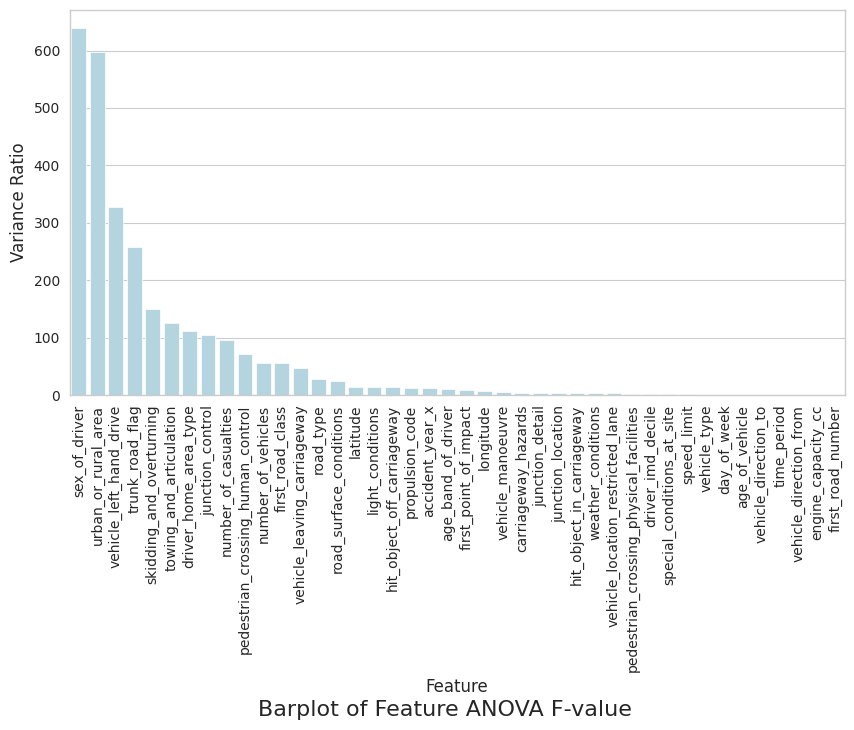

In [105]:
# Plot variance ratio for each feature
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
sns.barplot(x='Feature', y='Variance Ratio', data=f_values, palette=["#ADD8E6"]*len(f_values))
plt.xticks(rotation=90)
plt.ylabel("Variance Ratio")
plt.suptitle('Barplot of Feature ANOVA F-value', fontsize=16, x = 0.5, y=-0.5)
plt.show()

# ANOVA F-value indicates whether the mean of a feature differs 
# significantly across categories. If the F-value is large, it means that 
# the mean difference of the feature between different categories is large, 
# which may have a significant impact on the target variable; 
# if the F-value is small, it means that the mean difference of the feature 
# between different categories is small,
# may not be significantly related to the target variable.

# We might guess that the low ANOVA F-value features are less important 
# but it does not directly consider the relationship between features
# For better data mining and to avoid data leakage, 
# we do not perform feature selection here

### 2.1.4 Summary of Data Validation and Cleansing

A data dictionary was created to comprehensively understand the dataset, and erroneous data types were corrected.

Furthermore, missing values (e.g., -1) and meaningless values (e.g., Unkonwn) were removed from the dataset. 
Features irrelevant to the prediction of accident severity, such as accident_reference, were also eliminated. Redundant features, such as location_easting_osgr, which duplicated information provided by latitude and longitude, were removed as well.

The distributions of each feature were explored, revealing that numerical features exhibited a wide range of distributions and contained outliers. Further investigation confirmed that these outliers represented valid and accurate values, and thus, it was decided to retain them. On the other hand, some categorical features demonstrated highly concentrated distributions, suggesting that they might not serve as significant factors in predicting accident severity.

### 2.2 Exploratory Data Analysis and Data Visualization

In [106]:
eda= df6.copy()

#### 2.2.1 Distribution of Target

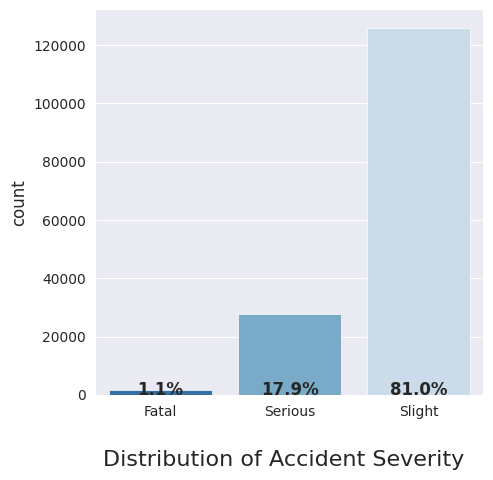

In [107]:
# Count the number of occurrences of each category in the 'accident_severity' column
counts = eda['accident_severity'].value_counts(normalize=True).sort_index()

# Plot the count of each category in a bar plot
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(data=eda, x='accident_severity', palette='Blues_r', ax=ax)

# Add the percentage annotation to each bar
for i, v in enumerate(counts):
    ax.text(i, v+0.01, f'{v:.1%}', ha='center', fontweight='bold', fontsize=12)

# Set the plot title and axis labels
plt.suptitle('Distribution of Accident Severity', fontsize=16, x=0.5, y=0.0)
sns.despine(top=True, right=True, left=True, bottom=True)
ax.set_xlabel('')
plt.show()


**Note**

In further exploratory analysis, it was observed that the distribution of the target variable, accident severity, exhibited significant class imbalance, with the 'Fatal' class accounting for only 1.1% of the data. This severe class imbalance can substantially hinder the predictive performance of the models (Ma and He, 2013). However, according to the definition of accident severity, it is based on the presence or absence of fatalities, serious injuries, or slight injuries (UK Government, no date). Considering the limited improvement in addressing the class imbalance through merging, it is deemed inappropriate to merge the classes.

#### 2.2.2 Time features

In [108]:
# Set date column as index and resample by month
df_agg_monthly =eda.set_index('Date').resample('M').size()

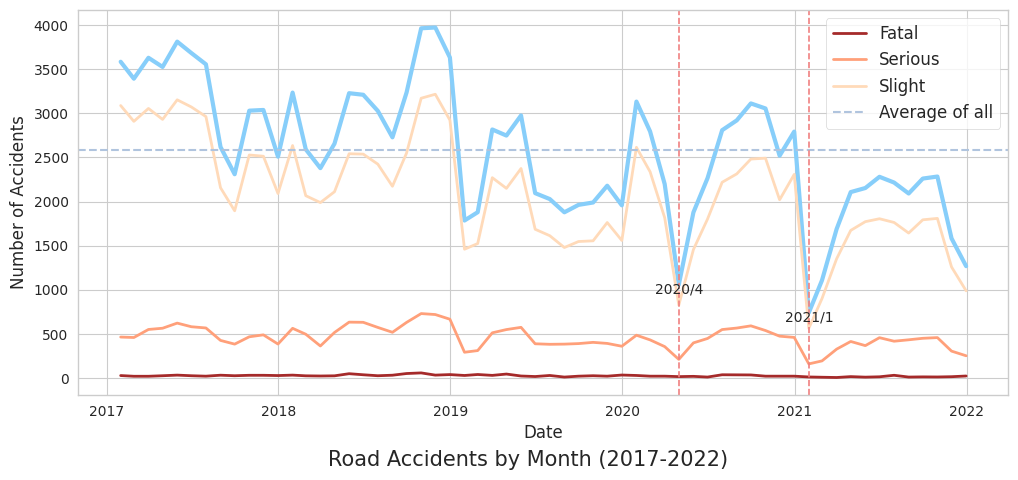

In [109]:
plt.style.use('ggplot')
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12, 5))

# plot total accidents by month
df_agg_monthly = eda.groupby('Date').size().resample('M').sum()
ax.plot(df_agg_monthly.index, df_agg_monthly, color='lightskyblue', linewidth=3)

# plot labels
severity_labels = sorted(eda['accident_severity'].unique())
severity_colors = {'Fatal': 'brown', 'Serious': 'lightsalmon', 'Slight': 'peachpuff'}
for label in severity_labels:
    severity = eda[eda['accident_severity'] == label].groupby('Date').size().resample('M').sum()
    ax.plot(severity.index, severity, color=severity_colors[label], linewidth=2, label=label)

mean = df_agg_monthly.mean()
min_val = df_agg_monthly.nsmallest(2).iloc[-1] 
min_idx = df_agg_monthly.index[df_agg_monthly.eq(min_val)][0]  
sec_min_val = df_agg_monthly.nsmallest(2).iloc[-2]  
sec_min_idx = df_agg_monthly.index[df_agg_monthly.eq(sec_min_val)][0]  

ax.axhline(mean, linestyle='--', color='lightsteelblue', label='Average of all', linewidth=1.5)
plt.legend(fontsize=12)

ax.axvline(x=min_idx, linestyle='--', color='lightcoral', linewidth=1.2)
ax.annotate(f'{min_idx.year}/{min_idx.month}', xy=(min_idx, min_val), xytext=(min_idx, min_val-100),
            ha='center', fontsize=10, arrowprops=dict(facecolor='black', arrowstyle='->'))

ax.axvline(x=sec_min_idx, linestyle='--', color='lightcoral', linewidth=1.2)
ax.annotate(f'{sec_min_idx.year}/{sec_min_idx.month}', xy=(sec_min_idx, sec_min_val), xytext=(sec_min_idx, sec_min_val-100),
            ha='center', fontsize=10, arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Accidents', fontsize=12)
plt.suptitle('Road Accidents by Month (2017-2022)', fontsize=15, x=0.5, y=0.0)

plt.show()


**Note**

Regarding the temporal aspect, the monthly number of accidents demonstrated certain cyclic patterns. Additionally, the lower number of accidents observed after 2020 compared to the five-year average could be attributed to the COVID-19 pandemic and the influence of traffic policies that affected traffic flow. The two lower points in the data correspond to periods of lockdown, indicating the impact of unforeseen factors such as policy changes. Considering the potential issue of data leakage and the influence of unpredictable factors, time series forecasting of accident numbers is deemed unsuitable.

Text(0.5, -0.05, 'Stacked Bar Chart-Proportion of Accident Severity by Time Period')

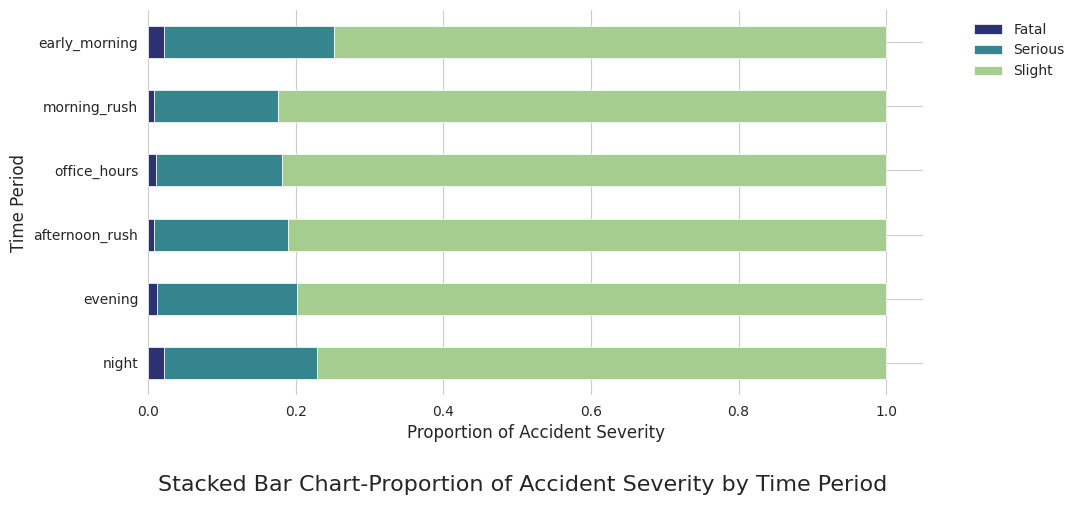

In [110]:
# prepare dataframe with counts
counts = eda.groupby(['time_period', 'accident_severity']).size().unstack('accident_severity', fill_value=0)
counts.columns = ['Fatal', 'Serious', 'Slight']
counts['sum'] = counts.sum(axis=1)

# prepare dataframe with shares
counts_share = counts.iloc[:, :-1].div(counts['sum'], axis=0)

# prepare barplot
fig, ax = plt.subplots(figsize=(10, 5))

# Define order of time periods
time_period_order = ['night', 'evening', 'afternoon_rush','office_hours','morning_rush','early_morning']

# plot
counts_share.reindex(time_period_order).plot(kind='barh', ax=ax, stacked=True, cmap='crest_r')

# Set title and axis labels
ax.set_xlabel('Proportion of Accident Severity')
ax.set_ylabel('Time Period')

# Add legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

# remove all spines
sns.despine(top=True, right=True, left=True, bottom=True)

# add figure title
plt.suptitle('Stacked Bar Chart-Proportion of Accident Severity by Time Period', fontsize=16, x=0.5, y=-0.05)

**Note**

By examining the proportions of the three severity categories during different time periods, it was observed that fatal and serious accidents were more likely to occur during the early morning and night time periods.

#### 2.2.3 Geographical features

In [111]:
g = gpd.GeoDataFrame(
    eda, geometry=gpd.points_from_xy(eda.longitude, eda.latitude), crs = "4326") 
#g.plot(marker='o', color='lightblue', markersize=1)
g = g.drop(['longitude', 'latitude'], axis=1)
#g.info()

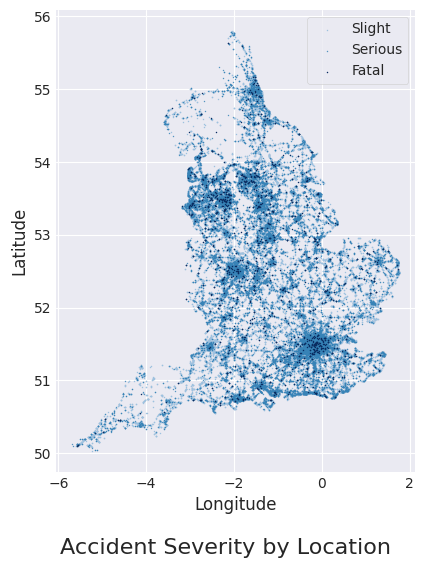

In [112]:
sns.set_style('darkgrid')

# Plot all GeoDataFrames on the same axis
fig, ax = plt.subplots(figsize=(8, 6))
g[g['accident_severity'] == 'Slight'].plot(ax=ax, markersize=0.3, color='#9dc1df', label='Slight')
g[g['accident_severity'] == 'Serious'].plot(ax=ax, markersize=0.3, color='#3783b7', label='Serious', alpha= 0.75)
g[g['accident_severity'] == 'Fatal'].plot(ax=ax, markersize=0.3, color='#0A2C61', label='Fatal')

# Set the axis labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.suptitle('Accident Severity by Location', fontsize=16, x=0.5, y=0.0)

# Remove the axis spines and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)

# Add the legend
plt.legend()

# Show the plot
plt.show()

**Note**

In terms of geographical features, accidents were found to cluster in Birmingham, London, Leeds, and Newcastle with a concentration of fatal accidents mainly observed in city centers.

#### 2.2.4 Numeric features

Running the code...


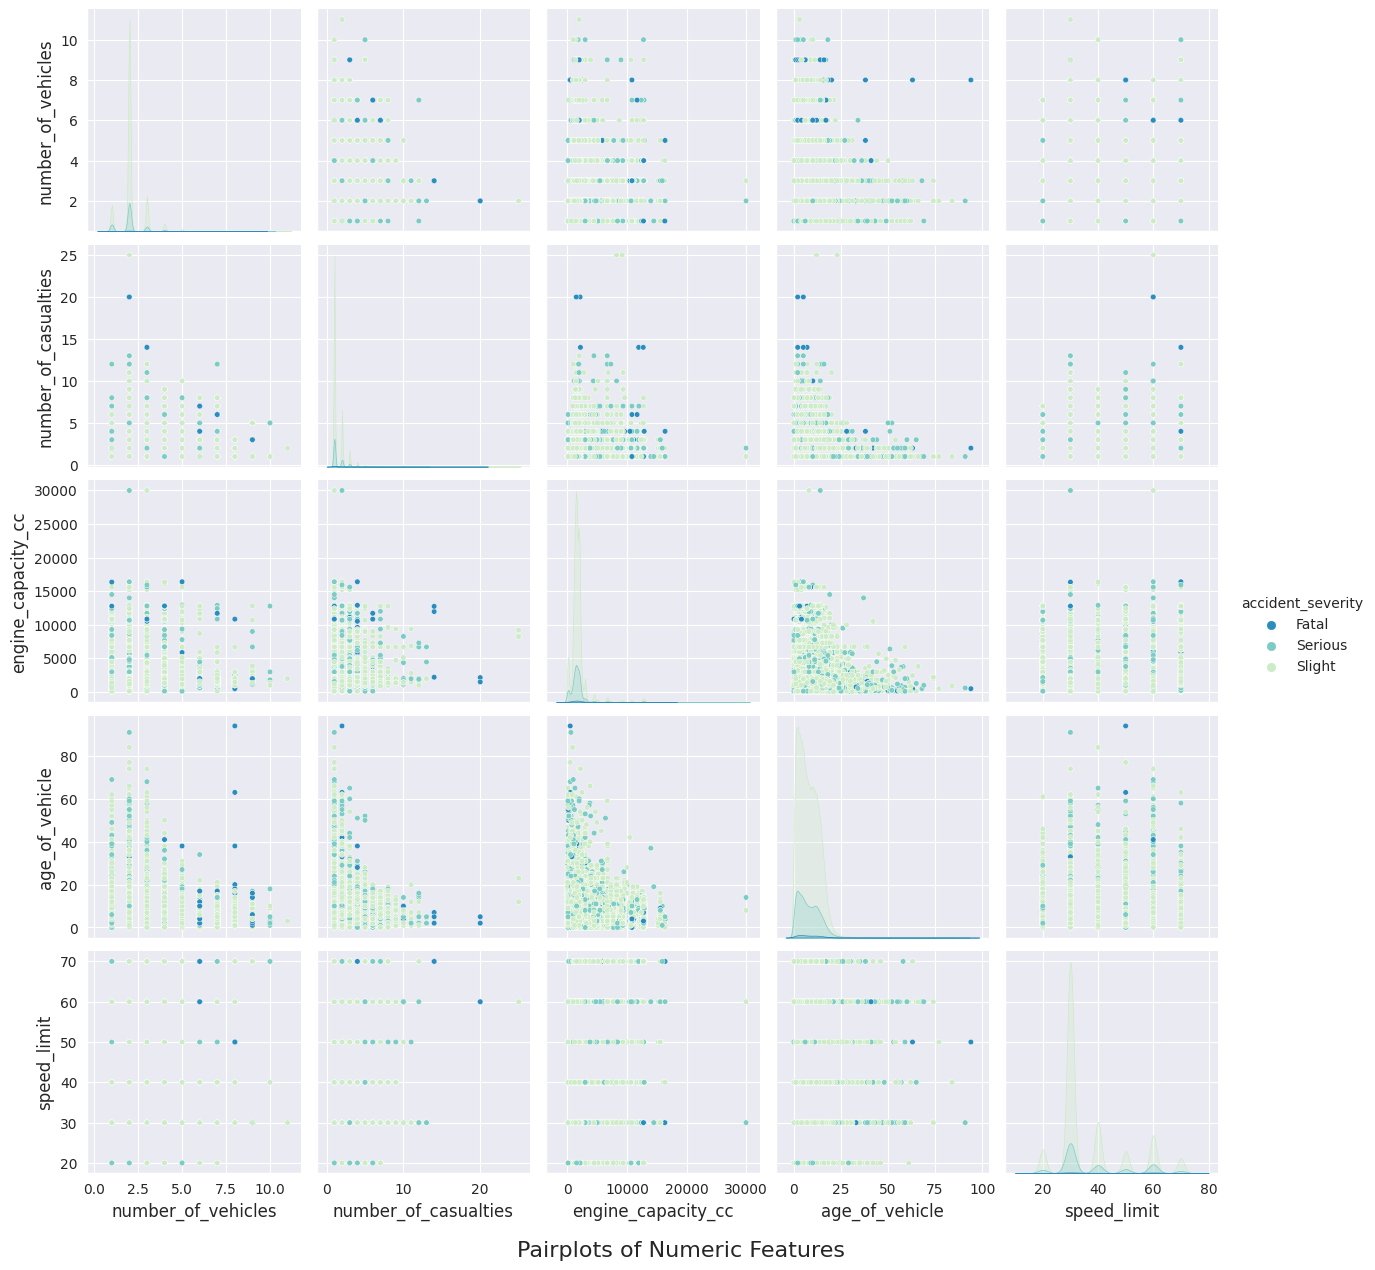

In [113]:
# It may automatically restart jupyternotebook kernal due to high RAM usage, 
# so it is set to non-automatic operation
# And takes 3 mins to plot
# The plot was inserted in markdown
run_code= False
if run_code:
  print("Running the code...")

  # Draw a pairwise relationship of continuous variables
  sns.set_style('darkgrid')

  cols = ['number_of_vehicles', 'number_of_casualties', 'engine_capacity_cc',
          'age_of_vehicle','accident_severity','speed_limit']
  sns.pairplot(eda[cols], diag_kind='kde',hue="accident_severity", palette='GnBu_r',
              plot_kws={"s": 16})
  plt.suptitle('Pairplots of Numeric Features', fontsize=16, x=0.5, y=0.0)
  plt.show()

else:
    # Code to be executed when the toggle switch is set to False
    print("Code execution is skipped.")


<img src="https://raw.githubusercontent.com/SeasoningPackkk/data/main/pairplot.jpeg">

**Note**

Exploring the numerical features revealed that fatal accidents were more likely to occur when more vehicles were involved and a greater number of casualties.

#### 2.2.5 Category features

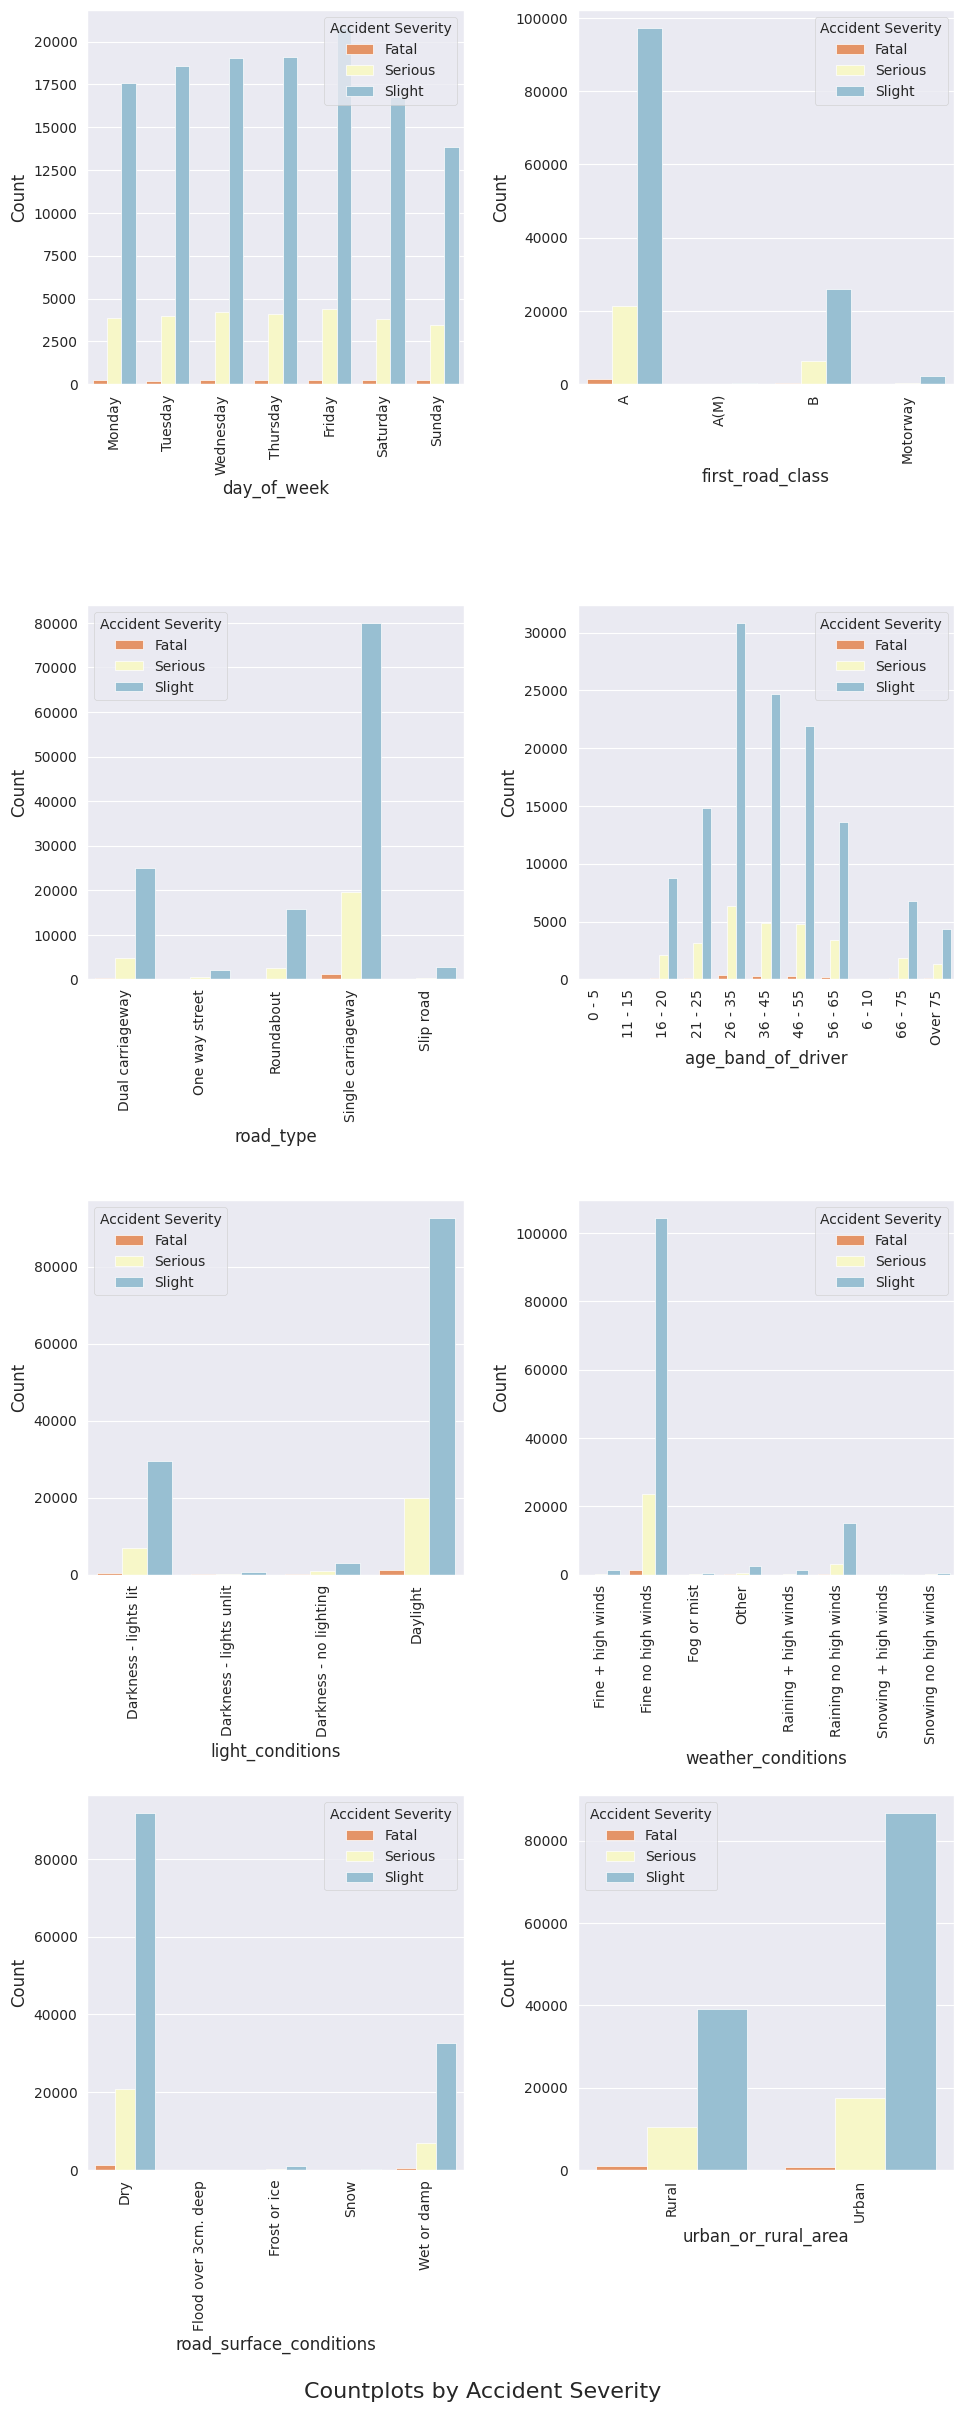

In [114]:
# Define the list of columns to plot
cols_to_plot = ['day_of_week', 'first_road_class', 'road_type', 'age_band_of_driver',
                'light_conditions', 'weather_conditions', 'road_surface_conditions',
                'urban_or_rural_area']

# Set the figure size and layout
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 24))

# Loop through the columns and plot countplots for each column with different hues based on 'accident_severity'
for i, col in enumerate(cols_to_plot):
    row = i // 2
    col_name = cols_to_plot[i]  # Get the column name
    ax = axs[row, i % 2]
    
    # Special handling for 'day_of_week' column
    if col_name == 'day_of_week':
        sns.countplot(data=eda, x=col_name, hue='accident_severity', palette='RdYlBu', ax=ax,
                      order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    else:
        sns.countplot(data=eda, x=col_name, hue='accident_severity', palette='RdYlBu', ax=ax)
    
    ax.set_ylabel('Count')
    ax.legend(title='Accident Severity')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Rotate xtick labels by 90 degrees

# Adjust the layout and spacing between subplots
fig.tight_layout(pad=2)
plt.suptitle('Countplots by Accident Severity', fontsize=16, x=0.5, y=0)

# Show the plot
plt.show()


**Note**

In the exploration of categorical features, significant differences were observed among the categories of day of the week, road type, driver age band, light conditions, weather conditions, road surface conditions, and urban or rural area for the three severity classes (Fatal, Serious, Slight). These differences could serve as important factors in predicting accident severity.

#### 2.2.6 Feature relationships 

<ipython-input-115-a1407f7cf199>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df5.corr(method="spearman")


Text(0.5, -0.1, 'Heatmap of Variable Correlations')

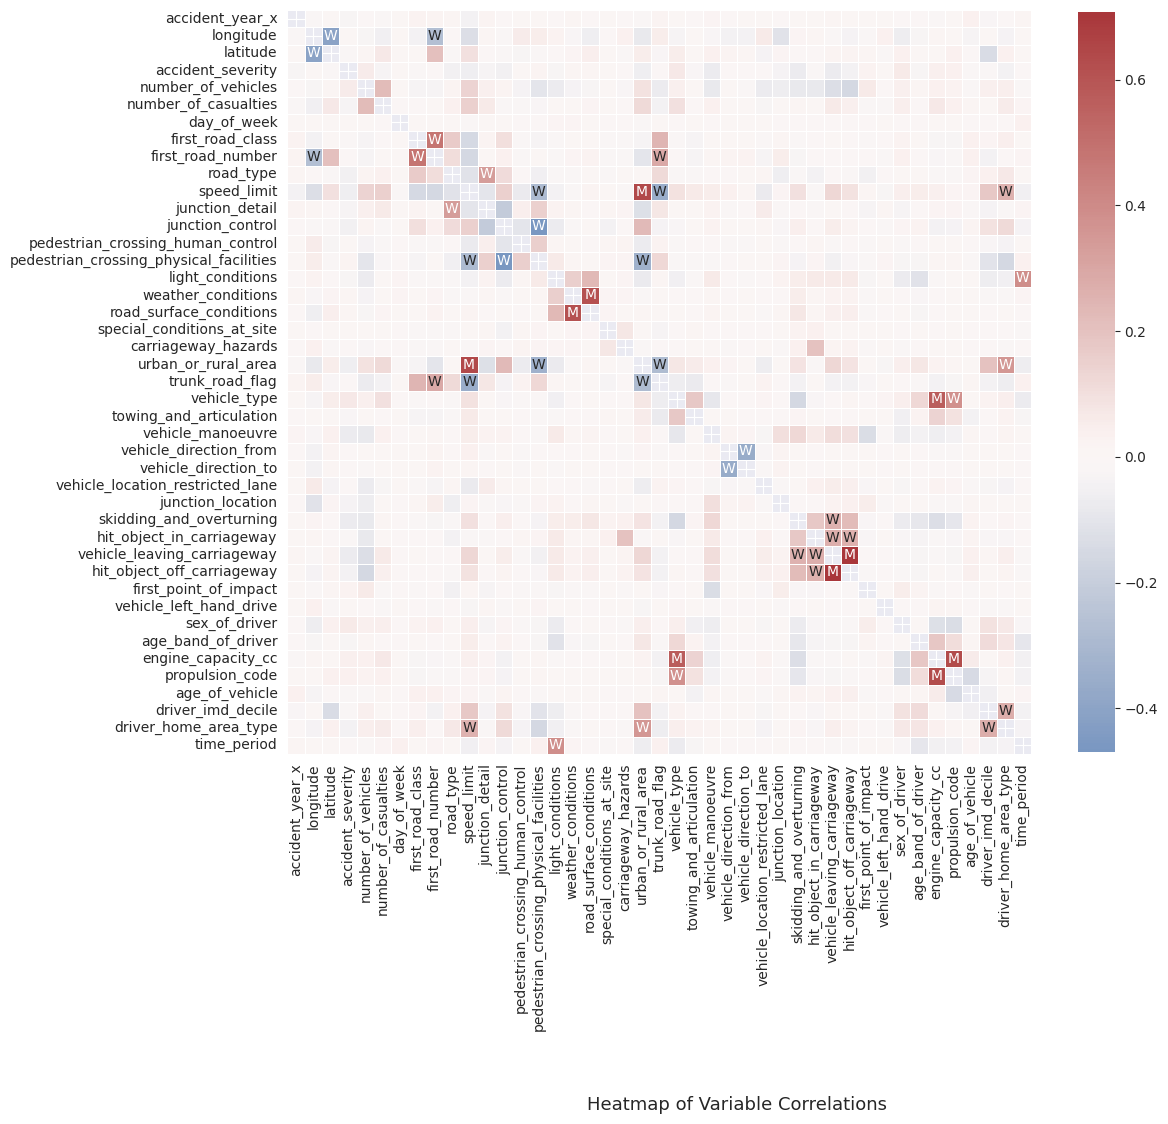

In [115]:

# Computes feature correlation
df_corr = df5.corr(method="spearman")

# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(12, 12))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

plt.suptitle('Heatmap of Variable Correlations', fontsize=13, x = 0.5, y=-0.1)

**Note**

No highly correlated features related to severity were identified, reducing the risk of overfitting.

In [116]:
# Pass the dataframe with data cleansing and type conversion to ml
ml = df6.drop(['Date', 'accident_index', 'accident_year_x'], axis=1)
print(ml.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155175 entries, 2 to 818006
Data columns (total 42 columns):
 #   Column                                   Non-Null Count   Dtype   
---  ------                                   --------------   -----   
 0   longitude                                155175 non-null  float64 
 1   latitude                                 155175 non-null  float64 
 2   accident_severity                        155175 non-null  category
 3   number_of_vehicles                       155175 non-null  int64   
 4   number_of_casualties                     155175 non-null  int64   
 5   day_of_week                              155175 non-null  category
 6   first_road_class                         155175 non-null  category
 7   first_road_number                        155175 non-null  category
 8   road_type                                155175 non-null  category
 9   speed_limit                              155175 non-null  float64 
 10  junction_detail     

In [117]:
# for col in ml.columns:
#     unique_values = eda[col].unique()
#     print(col, unique_values)


### 2.3 Data Summary
In conclusion, a dataset containing 155,175 samples was obtained, comprising 34 categorical features, 7 numerical features, and the target variable. In the subsequent machine learning process, data preprocessing will involve encoding the categorical features and normalizing the numerical features. Given the high imbalance in the target, it is imperative to consider further measures during the machine learning process.


## 3. Methodology

### 3.1 Model

In this notebook, five commonly used classifiers were employed and compared for accident severity prediction, including LogisticRegression, RandomForestClassifier, DecisionTreClassifier, BalancedRandomForestClassifier, and BalancedBaggingClassifier. The first three classifiers were assigned balanced weights, while the last two classifiers integrate balanced samplers so do not require additional weight adjustments. 

BRF demonstrated the best performance and was further subjected to hyperparameter tuning for better estimating the feature importance.
### 3.2 Data preprocessing

In data preprocessing, categorical features were transformed into binary form using OneHotEncoder to enable classifiers to handle them. Numerical features were scaled to the range between 0 and 1 using MinMaxScaler. This ensures consistent value ranges across different features and prevents certain features from exerting a disproportionate influence on the classifier. The resampling steps were integrated into the BalancedRandomForestClassifier and BalancedBaggingClassifier classifiers.
To avoid model overfitting caused by data leakage, all data preprocessing steps were performed within the pipeline after splitting the training and testing sets.

### 3.3 Feature importance
Feature importance was analyzed from two perspectives: overall importance and category-specific importance. To assess overall importance, we used permutation feature importance, randomly permuting feature values and measuring the resulting change in model performance (Breiman, 2001). For category-specific importance, we calculated feature importance based on Mean Decrease Impurity using Balanced Random Forest (BRF), which measures the effectiveness of features in reducing uncertainty or variance during Decision Tree creation (Breiman, 2001). These approaches revealed valuable insights into the underlying patterns in the data.


### 3.4 Modelling

#### 3.4.1 Training test set splitting

In [118]:
ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155175 entries, 2 to 818006
Data columns (total 42 columns):
 #   Column                                   Non-Null Count   Dtype   
---  ------                                   --------------   -----   
 0   longitude                                155175 non-null  float64 
 1   latitude                                 155175 non-null  float64 
 2   accident_severity                        155175 non-null  category
 3   number_of_vehicles                       155175 non-null  int64   
 4   number_of_casualties                     155175 non-null  int64   
 5   day_of_week                              155175 non-null  category
 6   first_road_class                         155175 non-null  category
 7   first_road_number                        155175 non-null  category
 8   road_type                                155175 non-null  category
 9   speed_limit                              155175 non-null  float64 
 10  junction_detail     

In [119]:
# Split the predictors and target in the ml data set
x = ml.drop(['accident_severity'], axis=1)  # predictors
y = ml['accident_severity']  # target
print(x.shape)
print(y.shape)
xs=x.copy()

(155175, 41)
(155175,)


In [120]:
# Split train-test data
x_train, x_test, y_train, y_test = train_test_split(xs, y, test_size=0.3, random_state=74)
print(f"Full size: {ml.shape}")
print(x_train.shape)
print(y_train.shape)
      
print("Test dataset size:")
print(x_test.shape)
print(y_test.shape)

Full size: (155175, 42)
(108622, 41)
(108622,)
Test dataset size:
(46553, 41)
(46553,)


#### 3.4.2 Data preprocessing

In [121]:
categorical_columns = xs.select_dtypes(include=['category']).columns.tolist()
numerical_columns = xs.select_dtypes(exclude=['category']).columns.tolist()

#print(categorical_columns, len(categorical_columns))
#print(numerical_columns, len(numerical_columns))

In [122]:

# Setting up the preprocessor
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Create classifiers
classifiers = {
    'LR': LogisticRegression(random_state=74,class_weight='balanced'),
    'RF': RandomForestClassifier(random_state=74,class_weight='balanced'),
    'BRF': BalancedRandomForestClassifier(random_state=74),
    'DT': DecisionTreeClassifier(random_state=74,class_weight='balanced'),
    'BBC': BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                             random_state=74)
}


#### 3.4.3 Running

In [123]:

# record reports
clfsco = {}

start_time = time.time()

for name, classifier in classifiers.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', classifier)]) # Creating the pipeline
    # Fitting the model and making predictions
    model=pipeline.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # Print classification_report_imbalanced
    report = classification_report_imbalanced(y_test, y_pred)
    print(f"Classifier: {name}")
    print(report)

    # Calculate and store the scores for each model
    clfsco[name] = [model.score(x_train, y_train),
                    model.score(x_test, y_test),  # accuracy score of test data
                    balanced_accuracy_score(y_test, y_pred),  # balanced accuracy score
                    geometric_mean_score(y_test, y_pred),  # geometric mean score
                    f1_score(y_test, y_pred,average='micro'),  # F1 score
                    cohen_kappa_score(y_test, y_pred) # kappa score
                    ]

# print results
clfsco = pd.DataFrame.from_dict(clfsco, orient='index', columns=['Training score',
                                                                 'Testing score',
                                                                 'Balanced accuracy',
                                                                 'Geometric mean',
                                                                 'F1',
                                                                 'Kappa score'])
print(clfsco)


end_time = time.time()
print("Execution time:", end_time - start_time, "seconds")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classifier: LR
                   pre       rec       spe        f1       geo       iba       sup

      Fatal       0.04      0.58      0.85      0.07      0.70      0.48       469
    Serious       0.25      0.44      0.72      0.32      0.56      0.30      8327
     Slight       0.88      0.58      0.65      0.70      0.62      0.38     37757

avg / total       0.76      0.56      0.67      0.62      0.61      0.36     46553

Classifier: RF
                   pre       rec       spe        f1       geo       iba       sup

      Fatal       1.00      0.01      1.00      0.02      0.09      0.01       469
    Serious       0.66      0.01      1.00      0.02      0.11      0.01      8327
     Slight       0.81      1.00      0.01      0.90      0.11      0.01     37757

avg / total       0.79      0.81      0.20      0.73      0.11      0.01     46553



/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.para

Classifier: BRF
                   pre       rec       spe        f1       geo       iba       sup

      Fatal       0.03      0.71      0.79      0.06      0.75      0.56       469
    Serious       0.23      0.33      0.76      0.27      0.50      0.24      8327
     Slight       0.88      0.57      0.66      0.69      0.61      0.37     37757

avg / total       0.75      0.53      0.68      0.61      0.59      0.35     46553

Classifier: DT
                   pre       rec       spe        f1       geo       iba       sup

      Fatal       0.08      0.15      0.98      0.10      0.38      0.13       469
    Serious       0.26      0.28      0.82      0.27      0.48      0.22      8327
     Slight       0.84      0.81      0.32      0.82      0.51      0.27     37757

avg / total       0.72      0.71      0.42      0.72      0.50      0.26     46553



/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


Classifier: BBC
                   pre       rec       spe        f1       geo       iba       sup

      Fatal       0.04      0.57      0.85      0.07      0.70      0.47       469
    Serious       0.22      0.44      0.65      0.29      0.54      0.28      8327
     Slight       0.88      0.53      0.68      0.66      0.60      0.35     37757

avg / total       0.75      0.51      0.68      0.59      0.59      0.34     46553

     Training score  Testing score  Balanced accuracy  Geometric mean  \
LR         0.572821       0.555195           0.532063        0.527573   
RF         1.000000       0.812321           0.339688        0.046298   
BRF        0.570409       0.530127           0.537087        0.510581   
DT         1.000000       0.708032           0.413138        0.323763   
BBC        0.536475       0.511589           0.513503        0.510677   

           F1  Kappa score  
LR   0.555195     0.123414  
RF   0.812321     0.017446  
BRF  0.530127     0.101289  
DT   0.7080

## 4 Results


### Classifier Performance Evaluation

In [124]:
clfsco

,Training score,Testing score,Balanced accuracy,Geometric mean,F1,Kappa score
LR,0.572821,0.555195,0.532063,0.527573,0.555195,0.123414
RF,1.000000,0.812321,0.339688,0.046298,0.812321,0.017446
BRF,0.570409,0.530127,0.537087,0.510581,0.530127,0.101289
DT,1.000000,0.708032,0.413138,0.323763,0.708032,0.110311
BBC,0.536475,0.511589,0.513503,0.510677,0.511589,0.094289


From the evaluation metrics of the different models, the following observations can be made:BRF, BBC, and LR with balanced weights achieved relatively high balanced accuracy, with scores above 0.50. Their relatively high Kappa scores indicate an advantage in addressing class imbalance issues. However, the lower training and testing scores may be attributed to the excessive focus on the minority class, which can result in the loss of important information from the majority class and lead to underfitting.

In summary, all five models have limitations in predicting accident severity. Although weighted RF, BRF, and BBC performed relatively well in handling class imbalance, there is still room for improvement in overall prediction accuracy. Given that BRF showed the best performance in predicting the Fatal category, which is of most concern, the next step would involve hyperparameter tuning to better analyze feature importance. 

### Hyperparameter tuning

In [125]:
start_time = time.time()

# Use BalancedRandomForestClassifier to perform parameter optimisation
clf=Pipeline(steps=[('preprocessor', preprocessor),
                    ('classifier', BalancedRandomForestClassifier(random_state=74))])

clf_fit = clf.fit(x_train, y_train)
clf_fit

end_time = time.time()
duration = end_time - start_time

# Print the runtime duration
print("Runtime duration: {:.2f} seconds".format(duration))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.para

Runtime duration: 10.66 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


In [126]:
# It takes 30 minutes to run hyperparameter optimisation 
# so it is set to non-automatic operation

run_code= False
if run_code:
  print("Running the code...")

  from sklearn.model_selection import GridSearchCV
  start_time= time.time
  # Define the parameter grid
  param_grid = {
      'classifier__max_depth': [10, 20,30,40,50],  # Maximum tree depth
      'classifier__min_samples_split': [2, 4, 6,8,10]  # Minimum number of samples required to split a node
  }

  # Perform grid search
  grid_search = GridSearchCV(clf, param_grid, scoring='balanced_accuracy', cv=5)
  grid_search.fit(x_train, y_train)

  # Output the best parameters and best score
  print("Best Score: ", grid_search.best_score_)
  print("Best Params: ", grid_search.best_params_)

  elapsed_time = time.time()
  print(f"Elapsed time: {elapsed_time} seconds")

else:
    # Code to be executed when the toggle switch is set to False
    print("Code execution is skipped.")

Code execution is skipped.


In [127]:
# Specify hyperparameters
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', BalancedRandomForestClassifier(random_state=74, max_depth=40,
                                                  min_samples_split=2))
])
# The n_estimators are not adjusted here due to computational limitations.
clf_fit = clf.fit(x_train, y_train)
clf_fit

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.para

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['longitude', 'latitude',
                                                   'number_of_vehicles',
                                                   'number_of_casualties',
                                                   'speed_limit',
                                                   'engine_capacity_cc',
                                                   'age_of_vehicle']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['day_of_week',
                                                   'first_road_class',
                                                   'fir...
                                                   'vehicle_direction_to',
                                                   'vehicle_location_restricted_lane',
                                                   'junction_location',
                                                   'skidding_and_overturning',
                                                   'hit_object_in_carriageway',
                                                   'vehicle_leaving_carriageway',
                                                   'hit_object_off_carriageway',
                                                   'first_point_of_impact',
                                                   'vehicle_left_hand_drive',
                                                   'sex_of_driver',
                                                   'age_band_of_driver', ...])])),
                ('classifier',
                 BalancedRandomForestClassifier(max_depth=40,
                                                random_state=74))])

### Results after hyperparametric tuning

In [128]:
y_pred = clf_fit.predict(x_test)

print(classification_report_imbalanced(y_test, y_pred))
print("Kappa Score:", cohen_kappa_score(y_test, y_pred))
print("Balanced accuracy score:", balanced_accuracy_score(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

      Fatal       0.03      0.72      0.80      0.07      0.76      0.57       469
    Serious       0.23      0.32      0.77      0.27      0.50      0.24      8327
     Slight       0.88      0.59      0.64      0.71      0.62      0.38     37757

avg / total       0.75      0.54      0.67      0.62      0.60      0.35     46553

Kappa Score: 0.10579723089057536
Balanced accuracy score: 0.5427615487861892


After hyperparameter tuning of the BRF model, the predictive results for each category are presented in the table.
The Kappa score of 0.10 indicates slight agreement beyond chance expectation, and the balanced accuracy score of 0.54 shows some improvement, suggesting enhancements in handling class imbalance issues. However, there is still a tendency to misclassify accidents in the Slight category as Fatal and need further improvement.

### Feature importance

Running the code...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.para

                                         Importance
Feature                                            
longitude                                    0.0162
age_band_of_driver                           0.0138
junction_location                            0.0130
sex_of_driver                                0.0130
time_period                                  0.0130
vehicle_direction_to                         0.0128
engine_capacity_cc                           0.0106
first_point_of_impact                        0.0100
vehicle_type                                 0.0094
vehicle_direction_from                       0.0086
junction_control                             0.0078
junction_detail                              0.0076
driver_imd_decile                            0.0076
propulsion_code                              0.0072
pedestrian_crossing_physical_facilities      0.0070
day_of_week                                  0.0070
first_road_number                            0.0070
latitude    

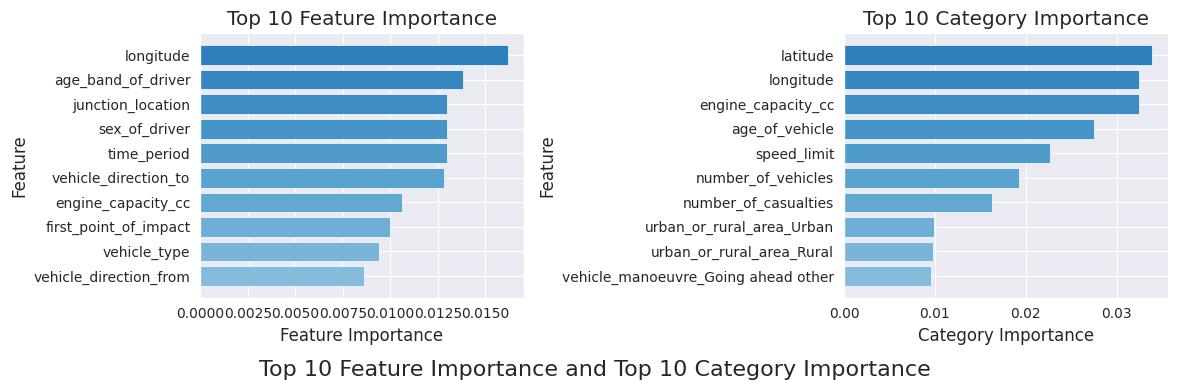

In [129]:
# It may automatically restart jupyternotebook kernal due to high RAM usage, 
# And it takes 20 minutes to run
# so it is set to non-automatic operation

run_code= False
if run_code:
  print("Running the code...")

  #Calculating the MDI of balanced random forests
  scaler = MinMaxScaler()
  scaled_numerical = scaler.fit_transform(x[numerical_columns])
  scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_columns, index=x.index)
  encoded_categorical = pd.get_dummies(x[categorical_columns])
  x_encoded = pd.concat([scaled_numerical_df, encoded_categorical], axis=1)

  clfea = BalancedRandomForestClassifier(random_state=74, max_depth=40, min_samples_split=2)
  clfea_fit = clfea.fit(x_encoded, y)

  # Calculate feature importances
  np.random.seed(74)
  importances = clfea.feature_importances_

  # Create a DataFrame for feature importance
  df_feature_importance = pd.DataFrame(importances,
                                      index=x_encoded.columns,
                                      columns=['Importance']).sort_values('Importance', ascending=False)

  # Sort the feature importance in descending order
  df_feature_importance = df_feature_importance.sort_values(by='Importance', ascending=False)

  # Computing Permutation Feature Importance
  np.random.seed(74)
  fi = rfpimp.importances(clf,x,y)
  print(fi)
  print(df_feature_importance)

    # Create a color map using blue color gradient
  color_map = plt.cm.Blues_r(np.linspace(0.3, 1, 25))

  # Create the subplots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

  # Plot the first bar chart using fi
  ax1.barh(fi.index[:10], fi['Importance'][:10], color=color_map)
  ax1.set_xlabel('Feature Importance')
  ax1.set_ylabel('Feature')
  ax1.set_title('Top 10 Feature Importance')

  # Plot the second bar chart using df_feature_importance
  ax2.barh(df_feature_importance.index[:10], 
          df_feature_importance['Importance'][:10], color=color_map)
  ax2.set_xlabel('Category Importance')
  ax2.set_ylabel('Feature')
  ax2.set_title('Top 10 Category Importance')

  # Invert the y-axis for both charts
  ax1.invert_yaxis()
  ax2.invert_yaxis()

  # Set the figure title
  fig.suptitle('Top 10 Feature Importance and Top 10 Category Importance', fontsize=16, y=0)

  # Adjust the spacing between subplots
  plt.tight_layout()

  # Show the plot
  plt.show()
else:
  # Code to be executed when the toggle switch is set to False
    
  fi = pd.read_csv('https://raw.githubusercontent.com/SeasoningPackkk/data/main/fi.csv')
  print(fi)

  # Print the feature importance results
  df_feature_importance = pd.read_csv('https://raw.githubusercontent.com/SeasoningPackkk/data/main/df_feature_importance.csv')
  print(df_feature_importance)

  # Create a color map using blue color gradient
  color_map = plt.cm.Blues_r(np.linspace(0.3, 1, 25))

  # Create the subplots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

  # Plot the first bar chart using fi
  ax1.barh(fi['Feature'][:10], fi['Importance'][:10], color=color_map)
  ax1.set_xlabel('Feature Importance')
  ax1.set_ylabel('Feature')
  ax1.set_title('Top 10 Feature Importance')

  # Plot the second bar chart using df_feature_importance
  ax2.barh(df_feature_importance['Unnamed: 0'][:10], 
          df_feature_importance['Importance'][:10], color=color_map)
  ax2.set_xlabel('Category Importance')
  ax2.set_ylabel('Feature')
  ax2.set_title('Top 10 Category Importance')

  # Invert the y-axis for both charts
  ax1.invert_yaxis()
  ax2.invert_yaxis()

  # Set the figure title
  fig.suptitle('Top 10 Feature Importance and Top 10 Category Importance', fontsize=16, y=0)

  # Adjust the spacing between subplots
  plt.tight_layout()

  # Show the plot
  plt.show()



From the overall feature importance results, it can be observed that location, driver age, junction location and gender etc. are the most important factors influencing the prediction of accident severity. In terms of specific categories, it is identified that urban area and vehicle going ahead other are important factors in differentiating accident severity.



## 5 Discussion and Conclusion

This notebook constructed and compared the classification performance of five machine learning algorithms and explored the important features influencing accident severity. The following are the answers to the three research questions:

RQ1 - **Factors**: From the feature importance analysis, we observed that important influencing factors in the features include location, driver age, junction location and gender. These findings provide additional insights to the previous work. In terms of specific categories, urban area, vehicle maneuvers such as going ahead other are found to be important factors distinguishing accident severity.

RQ2 - **Accuracy**: The BRF model achieved a balanced accuracy of 54% and a kappa score of 0.10, comparatively better than others, but still indicating challenges in capturing the differences between severity.

There could be two possible reasons for this: the highly imbalanced dataset and the presence of ineffective features. Future research can consider the following approaches: 1) Implement SMOTE, a technique suitable for highly imbalanced datasets, to address the issue of information loss and poor fitting caused by random undersampling in the classifier. 2) Conduct feature selection based on feature importance to eliminate features that introduce noise or interference and reduce the overall model performance. 3) Explore more advanced ensemble learning methods, such as the BBC-LGBM model proposed by Niyogisubizo et al. (2023).

RQ3 - **Patterns**: Through exploratory analysis and feature importance analysis, we discovered that the average number of accidents after 2020 was lower than the average between 2017 to 2021. This decrease was primarily observed in slight accidents, while fatal and serious accidents remained relatively stable. In terms of time periods, fatal and serious accidents were more likely to occur in the early morning and at night. Geographically, fatal accidents were concentrated in city centers.Regarding other features, it was found that fatal accidents were more likely to occur when there were a higher number of vehicles involved and a higher number of injured individuals. They were also more likely to happen on A-class roads and on single-lane roads.

In summary, these findings provide valuable insights for enhancing traffic safety and efficiency, as well as informing urban transportation planning.

In [130]:
end_time = time.time()
duration = end_time - start_time_1

# Print the runtime duration
print("Runtime duration: {:.2f} seconds".format(duration))

Runtime duration: 939.95 seconds



***
## References

AlMamlook, R. E., Kwayu, K. M., Alkasisbeh, M. R. and Frefer, A. A. (2019). ‘Comparison of Machine Learning Algorithms for Predicting Traffic Accident Severity’. in 2019 IEEE Jordan International Joint Conference on Electrical Engineering and Information Technology (JEEIT). 2019 IEEE Jordan International Joint Conference on Electrical Engineering and Information Technology (JEEIT), pp. 272–276. doi: 10.1109/JEEIT.2019.8717393.

Breiman, L. (2001). ‘Random Forests’. Machine Learning, 45 (1), pp. 5–32. doi: 10.1023/A:1010933404324.

Chen, C., Liaw, A., Breiman, L., and others. (2004). ‘Using random forest to learn imbalanced data’. University of California, Berkeley, 110 (1–12), p. 24.

Fiorentini, N. and Losa, M. (2020). ‘Handling Imbalanced Data in Road Crash Severity Prediction by Machine Learning Algorithms’. Infrastructures. Multidisciplinary Digital Publishing Institute, 5 (7), p. 61. doi: 10.3390/infrastructures5070061.
Ghandour, A. J., Hammoud, H. and Al-Hajj, S. (2020). ‘Analyzing Factors Associated with Fatal Road Crashes: A Machine Learning Approach’. International Journal of Environmental Research and Public Health, 17 (11), p. 4111. doi: 10.3390/ijerph17114111.

Global status report on road safety 2018. (no date). Available at: https://www.who.int/publications-detail-redirect/9789241565684 (Accessed: 21 April 2023).

Kumeda, B., Zhang, F., Zhou, F., Hussain, S., Almasri, A. and Assefa, M. (2019). ‘Classification of Road Traffic Accident Data Using Machine Learning Algorithms’. in 2019 IEEE 11th International Conference on Communication Software and Networks (ICCSN). 2019 IEEE 11th International Conference on Communication Software and Networks (ICCSN), pp. 682–687. doi: 10.1109/ICCSN.2019.8905362.

Ma, Y. and He, H. (2013). Imbalanced Learning: Foundations, Algorithms, and Applications. John Wiley & Sons.

Malik, S., El Sayed, H., Khan, M. A. and Khan, M. J. (2021). ‘Road Accident Severity Prediction — A Comparative Analysis of Machine Learning Algorithms’. in 2021 IEEE Global Conference on Artificial Intelligence and Internet of Things (GCAIoT). 2021 IEEE Global Conference on Artificial Intelligence and Internet of Things (GCAIoT), pp. 69–74. doi: 10.1109/GCAIoT53516.2021.9693055.

Megnidio-Tchoukouegno, M. and Adedeji, J. A. (2023). ‘Machine Learning for Road Traffic Accident Improvement and Environmental Resource Management in the Transportation Sector’. Sustainability. Multidisciplinary Digital Publishing Institute, 15 (3), p. 2014. doi: 10.3390/su15032014.

Niyogisubizo J., Liao L., Zou F., Han G., Nziyumva E., Li B. and Lin Y. (2023). ‘Predicting traffic crash severity using hybrid of balanced bagging classification and light gradient boosting machine’. Intelligent Data Analysis. IOS Press, 27 (1), pp. 79–101. doi: 10.3233/IDA-216398.

Reported road casualties in Great Britain: notes, definitions, symbols and conventions. (no date). GOV.UK. Available at: https://www.gov.uk/government/publications/road-accidents-and-safety-statistics-notes-and-definitions/reported-road-casualties-in-great-britain-notes-definitions-symbols-and-conventions (Accessed: 19 April 2023).

Schlögl, M. (2020). ‘A multivariate analysis of environmental effects on road accident occurrence using a balanced bagging approach’. Accident; Analysis and Prevention, 136, p. 105398. doi: 10.1016/j.aap.2019.105398.

***